In [5]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 데이터 로딩

In [7]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

dataset = datasets.CIFAR10( root = 'data',download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)

Files already downloaded and verified


# 자주 쓰이는 변수들 사전에 정의하기

In [8]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

# 생성기 네트워크 정의

`__init__` 함수 내부에서 여러 레이어를 정의하고 sequential 모델을 사용해 데이터의 흐름을 정의한다.

Generator 모델은 크기가 nz인 텐서를 입력으로 가져온 후, 이를 전치 컨볼루션에 전달해 입력을 생성해야 하는 이미지 크기에 대응시킨다.

forward 함수는 입력을 Sequential 모듈로 전달하고 출력을 반환한다.

Generator 네트워크의 마지막 레이어는 tanh다. 이 레이어는 Generator 네트워크가 생성하는 값의 범위를 한정한다.

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # 입력 : Z, 컨볼루션에 전달
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 상태 크기 : (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 상태 크기 : (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 상태 크기 : (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 상태 크기 : (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 상태 크기 : (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

# 가중치 초기화를 위한 함수 정의

임의의 수로 가중치를 초기화하는 방법 대신, 논문에 정의된 가중치를 사용해 모델을 초기화한다.

In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

생성기 객체인 netG의 apply 메서드에 weight_init 함수를 매개변수로 입력하면 weight_init 함수가 각 레이어마다 호출된다.

weight_init 함수가 호출될 때, netG의 각 레이어가 함수의 전달 인자로 제공된다.

이때 입력된 레이어가 컨볼루션 레이어일 경우 평균이 0, 표준편차가 0.02가 되도록 초기화하고,

배치 정규화 레이어일 경우 평균이 1, 표준편차가 0.02가 되도록 초기화한다.

In [14]:
netG = Generator()
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# 판별기 네트워크 정의

판별기 네트워크에서 두 가지 중요한 특징은 활성화 함수로 Leaky ReLU를 사용하고 마지막 활성화 레이어로 시그모이드를 사용하는 것이다.

먼저 Leaky ReLU는 죽어가는 ReLU 문제를 해결하기 위한 함수로 Leaky ReLU는 입력이 음수일 때 0을 반환하는 ReLU 함수와 다르게 0.001과 같은 매우 작은 숫자를 출력한다.

GAN 논문에서, Leaky ReLU를 사용하면 판별기 네트워크 성능이 향상되는 것으로 보고되고 있다.

또 다른 중요한 차이점은 판별기 네트워크의 마지막에 전연결 레이어를 사용하지 않고 바로 시그모이드를 사용한다는 것이다.

마지막으로 전연결 레이어를 사용하면 전역 평균 폴링이 되는데 이는 수렴 속도(정확한 분류자를 만드는 데 필요한 반복 횟수)가 줄어들어 학습이 더 안 된다고 한다.

따라서 컨볼루션 레이어 다음에 바로 시그모이드 레이어가 연결된다.

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [16]:
netD = Discriminator()
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 오차 함수 정의

오차 함수로는  이진 교차 엔트로피 오차를 사용한다.

또한 다음 코드에서는 입력될 데이터의 형상과 판별기의 label 값(진짜 이미지인지, 가짜 이미지인지)을 정의한다.

In [17]:
criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [20]:
if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()
    
fixed_noise = Variable(fixed_noise)

# 옵티마이저 정의

2개의 옵티마이저를 정의한다.

하나는 생성기 네트워크를 위한 옵티마이저이고, 나머지 하나는 판별기 네트워크를 위한 옵티마이저이다.

In [21]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

# 학습

In [23]:
%%time
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data.item(), errG.data.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

[0/25][0/782] Loss_D: 1.7293 Loss_G: 6.0796 D(x): 0.8313 D(G(z)): 0.6984 / 0.0042
[0/25][1/782] Loss_D: 1.0732 Loss_G: 6.5428 D(x): 0.7136 D(G(z)): 0.3781 / 0.0021
[0/25][2/782] Loss_D: 0.9664 Loss_G: 5.6821 D(x): 0.6459 D(G(z)): 0.2552 / 0.0043
[0/25][3/782] Loss_D: 1.0231 Loss_G: 6.2861 D(x): 0.6908 D(G(z)): 0.3549 / 0.0025
[0/25][4/782] Loss_D: 0.9465 Loss_G: 7.9166 D(x): 0.7679 D(G(z)): 0.4078 / 0.0005
[0/25][5/782] Loss_D: 0.7584 Loss_G: 6.9255 D(x): 0.6766 D(G(z)): 0.1844 / 0.0015
[0/25][6/782] Loss_D: 0.8939 Loss_G: 8.4436 D(x): 0.8065 D(G(z)): 0.3849 / 0.0003
[0/25][7/782] Loss_D: 0.7223 Loss_G: 8.4446 D(x): 0.7637 D(G(z)): 0.2478 / 0.0004
[0/25][8/782] Loss_D: 0.6706 Loss_G: 8.6271 D(x): 0.7893 D(G(z)): 0.2517 / 0.0003
[0/25][9/782] Loss_D: 0.4834 Loss_G: 8.0716 D(x): 0.8035 D(G(z)): 0.1649 / 0.0004
[0/25][10/782] Loss_D: 0.6108 Loss_G: 9.8055 D(x): 0.8351 D(G(z)): 0.3000 / 0.0001
[0/25][11/782] Loss_D: 0.4594 Loss_G: 8.0428 D(x): 0.7792 D(G(z)): 0.1235 / 0.0004
[0/25][12/782]

[0/25][99/782] Loss_D: 0.6098 Loss_G: 7.5607 D(x): 0.8624 D(G(z)): 0.3147 / 0.0009
[0/25][100/782] Loss_D: 0.2573 Loss_G: 7.1927 D(x): 0.8341 D(G(z)): 0.0059 / 0.0016
[0/25][101/782] Loss_D: 0.3976 Loss_G: 3.3593 D(x): 0.7780 D(G(z)): 0.0420 / 0.0594
[0/25][102/782] Loss_D: 0.4759 Loss_G: 6.6042 D(x): 0.9669 D(G(z)): 0.3191 / 0.0028
[0/25][103/782] Loss_D: 0.2658 Loss_G: 5.7588 D(x): 0.8342 D(G(z)): 0.0165 / 0.0055
[0/25][104/782] Loss_D: 0.1368 Loss_G: 4.3564 D(x): 0.9294 D(G(z)): 0.0499 / 0.0179
[0/25][105/782] Loss_D: 0.1865 Loss_G: 4.7912 D(x): 0.9535 D(G(z)): 0.1233 / 0.0122
[0/25][106/782] Loss_D: 0.4230 Loss_G: 5.7417 D(x): 0.8620 D(G(z)): 0.1838 / 0.0057
[0/25][107/782] Loss_D: 0.4357 Loss_G: 2.6895 D(x): 0.7456 D(G(z)): 0.0447 / 0.0880
[0/25][108/782] Loss_D: 0.6616 Loss_G: 9.6812 D(x): 0.9804 D(G(z)): 0.4435 / 0.0002
[0/25][109/782] Loss_D: 0.7531 Loss_G: 5.8610 D(x): 0.6007 D(G(z)): 0.0023 / 0.0105
[0/25][110/782] Loss_D: 0.1443 Loss_G: 3.8641 D(x): 0.9248 D(G(z)): 0.0495 / 

[0/25][197/782] Loss_D: 0.1122 Loss_G: 5.3532 D(x): 0.9601 D(G(z)): 0.0639 / 0.0069
[0/25][198/782] Loss_D: 0.3892 Loss_G: 10.2138 D(x): 0.9597 D(G(z)): 0.2577 / 0.0001
[0/25][199/782] Loss_D: 0.5395 Loss_G: 7.1832 D(x): 0.6669 D(G(z)): 0.0015 / 0.0011
[0/25][200/782] Loss_D: 0.1049 Loss_G: 3.9535 D(x): 0.9323 D(G(z)): 0.0176 / 0.0276
[0/25][201/782] Loss_D: 0.7308 Loss_G: 11.9199 D(x): 0.9788 D(G(z)): 0.4845 / 0.0000
[0/25][202/782] Loss_D: 0.8848 Loss_G: 8.7315 D(x): 0.5599 D(G(z)): 0.0002 / 0.0005
[0/25][203/782] Loss_D: 0.0861 Loss_G: 4.7848 D(x): 0.9367 D(G(z)): 0.0128 / 0.0173
[0/25][204/782] Loss_D: 0.4861 Loss_G: 9.3823 D(x): 0.9780 D(G(z)): 0.3121 / 0.0002
[0/25][205/782] Loss_D: 0.2554 Loss_G: 8.2886 D(x): 0.8145 D(G(z)): 0.0036 / 0.0007
[0/25][206/782] Loss_D: 0.1854 Loss_G: 5.7084 D(x): 0.8596 D(G(z)): 0.0076 / 0.0058
[0/25][207/782] Loss_D: 0.1834 Loss_G: 5.3602 D(x): 0.9668 D(G(z)): 0.1221 / 0.0085
[0/25][208/782] Loss_D: 0.2037 Loss_G: 6.1404 D(x): 0.9407 D(G(z)): 0.1203

[0/25][295/782] Loss_D: 0.0412 Loss_G: 11.8709 D(x): 0.9671 D(G(z)): 0.0044 / 0.0001
[0/25][296/782] Loss_D: 0.2445 Loss_G: 8.9237 D(x): 0.8648 D(G(z)): 0.0035 / 0.0008
[0/25][297/782] Loss_D: 0.0663 Loss_G: 6.7103 D(x): 0.9903 D(G(z)): 0.0506 / 0.0026
[0/25][298/782] Loss_D: 0.1983 Loss_G: 8.6831 D(x): 0.9628 D(G(z)): 0.1364 / 0.0006
[0/25][299/782] Loss_D: 0.1614 Loss_G: 7.8792 D(x): 0.9108 D(G(z)): 0.0329 / 0.0008
[0/25][300/782] Loss_D: 0.2457 Loss_G: 5.6937 D(x): 0.8760 D(G(z)): 0.0439 / 0.0070
[0/25][301/782] Loss_D: 0.2340 Loss_G: 11.8342 D(x): 0.9931 D(G(z)): 0.1776 / 0.0000
[0/25][302/782] Loss_D: 0.1473 Loss_G: 11.2360 D(x): 0.9144 D(G(z)): 0.0005 / 0.0000
[0/25][303/782] Loss_D: 0.1903 Loss_G: 6.6483 D(x): 0.8894 D(G(z)): 0.0009 / 0.0035
[0/25][304/782] Loss_D: 0.1288 Loss_G: 5.5201 D(x): 0.9611 D(G(z)): 0.0730 / 0.0091
[0/25][305/782] Loss_D: 0.4520 Loss_G: 13.1470 D(x): 0.9827 D(G(z)): 0.2868 / 0.0000
[0/25][306/782] Loss_D: 1.2334 Loss_G: 7.5090 D(x): 0.5479 D(G(z)): 0.00

[0/25][393/782] Loss_D: 0.6359 Loss_G: 4.7266 D(x): 0.8644 D(G(z)): 0.3444 / 0.0149
[0/25][394/782] Loss_D: 0.4304 Loss_G: 3.9988 D(x): 0.7510 D(G(z)): 0.0787 / 0.0306
[0/25][395/782] Loss_D: 0.4458 Loss_G: 3.0304 D(x): 0.8138 D(G(z)): 0.1592 / 0.0767
[0/25][396/782] Loss_D: 0.3010 Loss_G: 4.0514 D(x): 0.9040 D(G(z)): 0.1591 / 0.0246
[0/25][397/782] Loss_D: 0.5333 Loss_G: 4.3051 D(x): 0.8161 D(G(z)): 0.2324 / 0.0243
[0/25][398/782] Loss_D: 0.5971 Loss_G: 2.8100 D(x): 0.7110 D(G(z)): 0.1431 / 0.1047
[0/25][399/782] Loss_D: 0.4812 Loss_G: 3.5190 D(x): 0.8611 D(G(z)): 0.2065 / 0.0371
[0/25][400/782] Loss_D: 0.4137 Loss_G: 5.0149 D(x): 0.8949 D(G(z)): 0.2228 / 0.0114
[0/25][401/782] Loss_D: 0.4762 Loss_G: 2.9544 D(x): 0.7195 D(G(z)): 0.0389 / 0.0873
[0/25][402/782] Loss_D: 0.6266 Loss_G: 4.2808 D(x): 0.8701 D(G(z)): 0.3121 / 0.0205
[0/25][403/782] Loss_D: 0.4779 Loss_G: 3.7324 D(x): 0.7930 D(G(z)): 0.1602 / 0.0313
[0/25][404/782] Loss_D: 0.4638 Loss_G: 4.6753 D(x): 0.8603 D(G(z)): 0.2292 /

[0/25][491/782] Loss_D: 0.2866 Loss_G: 5.3995 D(x): 0.9081 D(G(z)): 0.1556 / 0.0061
[0/25][492/782] Loss_D: 0.3105 Loss_G: 4.4858 D(x): 0.8262 D(G(z)): 0.0907 / 0.0148
[0/25][493/782] Loss_D: 0.3280 Loss_G: 6.9298 D(x): 0.9208 D(G(z)): 0.2075 / 0.0013
[0/25][494/782] Loss_D: 0.3853 Loss_G: 4.4045 D(x): 0.7333 D(G(z)): 0.0161 / 0.0182
[0/25][495/782] Loss_D: 0.4507 Loss_G: 6.8946 D(x): 0.9178 D(G(z)): 0.2750 / 0.0014
[0/25][496/782] Loss_D: 0.3637 Loss_G: 5.3487 D(x): 0.7575 D(G(z)): 0.0148 / 0.0088
[0/25][497/782] Loss_D: 0.1763 Loss_G: 4.5418 D(x): 0.9388 D(G(z)): 0.1007 / 0.0144
[0/25][498/782] Loss_D: 0.2794 Loss_G: 7.3233 D(x): 0.9782 D(G(z)): 0.2055 / 0.0009
[0/25][499/782] Loss_D: 0.0712 Loss_G: 7.6460 D(x): 0.9436 D(G(z)): 0.0085 / 0.0012
[0/25][500/782] Loss_D: 0.1433 Loss_G: 5.1626 D(x): 0.9263 D(G(z)): 0.0172 / 0.0089
[0/25][501/782] Loss_D: 0.2110 Loss_G: 5.5636 D(x): 0.9608 D(G(z)): 0.1476 / 0.0050
[0/25][502/782] Loss_D: 0.2051 Loss_G: 5.3255 D(x): 0.9113 D(G(z)): 0.0935 /

[0/25][589/782] Loss_D: 0.2779 Loss_G: 3.6813 D(x): 0.8399 D(G(z)): 0.0795 / 0.0373
[0/25][590/782] Loss_D: 0.3734 Loss_G: 6.4265 D(x): 0.9506 D(G(z)): 0.2545 / 0.0024
[0/25][591/782] Loss_D: 0.6765 Loss_G: 3.3439 D(x): 0.6234 D(G(z)): 0.0232 / 0.0767
[0/25][592/782] Loss_D: 0.3196 Loss_G: 6.4438 D(x): 0.9595 D(G(z)): 0.2161 / 0.0027
[0/25][593/782] Loss_D: 0.1588 Loss_G: 5.7086 D(x): 0.9232 D(G(z)): 0.0411 / 0.0086
[0/25][594/782] Loss_D: 0.3434 Loss_G: 5.3347 D(x): 0.8851 D(G(z)): 0.1615 / 0.0097
[0/25][595/782] Loss_D: 0.3039 Loss_G: 4.1209 D(x): 0.8538 D(G(z)): 0.0955 / 0.0275
[0/25][596/782] Loss_D: 0.9426 Loss_G: 10.5663 D(x): 0.9285 D(G(z)): 0.5059 / 0.0001
[0/25][597/782] Loss_D: 3.8301 Loss_G: 3.4089 D(x): 0.0761 D(G(z)): 0.0010 / 0.0860
[0/25][598/782] Loss_D: 0.4753 Loss_G: 3.6803 D(x): 0.9156 D(G(z)): 0.2750 / 0.0402
[0/25][599/782] Loss_D: 0.4565 Loss_G: 5.1245 D(x): 0.9009 D(G(z)): 0.2236 / 0.0084
[0/25][600/782] Loss_D: 0.5362 Loss_G: 3.0606 D(x): 0.6928 D(G(z)): 0.0602 

[0/25][687/782] Loss_D: 0.1735 Loss_G: 4.8219 D(x): 0.9257 D(G(z)): 0.0840 / 0.0124
[0/25][688/782] Loss_D: 0.1411 Loss_G: 5.1724 D(x): 0.9536 D(G(z)): 0.0842 / 0.0092
[0/25][689/782] Loss_D: 0.2448 Loss_G: 3.8411 D(x): 0.8537 D(G(z)): 0.0537 / 0.0298
[0/25][690/782] Loss_D: 0.3454 Loss_G: 4.8289 D(x): 0.8844 D(G(z)): 0.1831 / 0.0109
[0/25][691/782] Loss_D: 0.2927 Loss_G: 4.6089 D(x): 0.8647 D(G(z)): 0.1151 / 0.0148
[0/25][692/782] Loss_D: 0.3715 Loss_G: 3.4373 D(x): 0.8036 D(G(z)): 0.0893 / 0.0407
[0/25][693/782] Loss_D: 0.5386 Loss_G: 5.7211 D(x): 0.8442 D(G(z)): 0.2712 / 0.0045
[0/25][694/782] Loss_D: 0.4964 Loss_G: 3.2425 D(x): 0.6953 D(G(z)): 0.0458 / 0.0603
[0/25][695/782] Loss_D: 0.8521 Loss_G: 5.8573 D(x): 0.9047 D(G(z)): 0.4764 / 0.0047
[0/25][696/782] Loss_D: 0.5327 Loss_G: 2.4670 D(x): 0.6829 D(G(z)): 0.0518 / 0.1264
[0/25][697/782] Loss_D: 0.9183 Loss_G: 8.9520 D(x): 0.9425 D(G(z)): 0.5022 / 0.0004
[0/25][698/782] Loss_D: 1.1021 Loss_G: 5.8712 D(x): 0.4385 D(G(z)): 0.0025 /

[1/25][3/782] Loss_D: 0.2946 Loss_G: 4.3284 D(x): 0.8503 D(G(z)): 0.0740 / 0.0259
[1/25][4/782] Loss_D: 0.3024 Loss_G: 3.4070 D(x): 0.8764 D(G(z)): 0.1251 / 0.0498
[1/25][5/782] Loss_D: 0.1679 Loss_G: 4.1348 D(x): 0.9582 D(G(z)): 0.1074 / 0.0275
[1/25][6/782] Loss_D: 0.4256 Loss_G: 3.3926 D(x): 0.8394 D(G(z)): 0.1625 / 0.0508
[1/25][7/782] Loss_D: 0.6560 Loss_G: 4.5057 D(x): 0.8615 D(G(z)): 0.3416 / 0.0161
[1/25][8/782] Loss_D: 1.3980 Loss_G: 1.3875 D(x): 0.3701 D(G(z)): 0.0796 / 0.3228
[1/25][9/782] Loss_D: 1.5993 Loss_G: 6.0336 D(x): 0.9211 D(G(z)): 0.7062 / 0.0050
[1/25][10/782] Loss_D: 0.6526 Loss_G: 4.7014 D(x): 0.6019 D(G(z)): 0.0534 / 0.0194
[1/25][11/782] Loss_D: 0.6013 Loss_G: 2.5713 D(x): 0.6096 D(G(z)): 0.0357 / 0.1297
[1/25][12/782] Loss_D: 0.6863 Loss_G: 3.3713 D(x): 0.8616 D(G(z)): 0.3560 / 0.0473
[1/25][13/782] Loss_D: 0.4976 Loss_G: 5.4290 D(x): 0.9325 D(G(z)): 0.3121 / 0.0060
[1/25][14/782] Loss_D: 0.2524 Loss_G: 5.1902 D(x): 0.8255 D(G(z)): 0.0275 / 0.0089
[1/25][15/7

[1/25][103/782] Loss_D: 0.3154 Loss_G: 3.4659 D(x): 0.8321 D(G(z)): 0.0792 / 0.0578
[1/25][104/782] Loss_D: 0.3784 Loss_G: 4.3542 D(x): 0.9368 D(G(z)): 0.2246 / 0.0221
[1/25][105/782] Loss_D: 0.3775 Loss_G: 4.2996 D(x): 0.8426 D(G(z)): 0.1115 / 0.0249
[1/25][106/782] Loss_D: 0.4728 Loss_G: 5.3063 D(x): 0.8744 D(G(z)): 0.2321 / 0.0099
[1/25][107/782] Loss_D: 0.3772 Loss_G: 4.2679 D(x): 0.7615 D(G(z)): 0.0448 / 0.0255
[1/25][108/782] Loss_D: 0.3733 Loss_G: 3.0065 D(x): 0.8105 D(G(z)): 0.1006 / 0.0667
[1/25][109/782] Loss_D: 0.6147 Loss_G: 5.2153 D(x): 0.8968 D(G(z)): 0.3316 / 0.0082
[1/25][110/782] Loss_D: 0.2332 Loss_G: 4.6806 D(x): 0.8583 D(G(z)): 0.0521 / 0.0136
[1/25][111/782] Loss_D: 0.4445 Loss_G: 4.6435 D(x): 0.8498 D(G(z)): 0.1955 / 0.0199
[1/25][112/782] Loss_D: 0.3921 Loss_G: 4.1116 D(x): 0.8094 D(G(z)): 0.1264 / 0.0273
[1/25][113/782] Loss_D: 0.3057 Loss_G: 3.8515 D(x): 0.8609 D(G(z)): 0.1177 / 0.0294
[1/25][114/782] Loss_D: 0.3323 Loss_G: 5.1632 D(x): 0.9067 D(G(z)): 0.1788 /

[1/25][201/782] Loss_D: 0.7450 Loss_G: 1.7657 D(x): 0.5961 D(G(z)): 0.0686 / 0.2607
[1/25][202/782] Loss_D: 0.6536 Loss_G: 5.2507 D(x): 0.8478 D(G(z)): 0.3282 / 0.0098
[1/25][203/782] Loss_D: 0.7392 Loss_G: 2.7122 D(x): 0.6042 D(G(z)): 0.0516 / 0.1000
[1/25][204/782] Loss_D: 0.3319 Loss_G: 2.4922 D(x): 0.9155 D(G(z)): 0.1859 / 0.1264
[1/25][205/782] Loss_D: 0.7179 Loss_G: 4.4437 D(x): 0.8501 D(G(z)): 0.3605 / 0.0184
[1/25][206/782] Loss_D: 0.7697 Loss_G: 2.2135 D(x): 0.6151 D(G(z)): 0.1043 / 0.1615
[1/25][207/782] Loss_D: 0.4950 Loss_G: 3.7148 D(x): 0.8973 D(G(z)): 0.2841 / 0.0441
[1/25][208/782] Loss_D: 0.5134 Loss_G: 2.8441 D(x): 0.7566 D(G(z)): 0.1524 / 0.0918
[1/25][209/782] Loss_D: 0.2975 Loss_G: 4.4873 D(x): 0.9051 D(G(z)): 0.1640 / 0.0171
[1/25][210/782] Loss_D: 0.3822 Loss_G: 2.5225 D(x): 0.7568 D(G(z)): 0.0452 / 0.1157
[1/25][211/782] Loss_D: 0.4374 Loss_G: 3.3944 D(x): 0.8897 D(G(z)): 0.2417 / 0.0500
[1/25][212/782] Loss_D: 0.2581 Loss_G: 3.9377 D(x): 0.8989 D(G(z)): 0.1253 /

[1/25][299/782] Loss_D: 0.4441 Loss_G: 3.3577 D(x): 0.7555 D(G(z)): 0.0568 / 0.0578
[1/25][300/782] Loss_D: 0.4164 Loss_G: 4.4066 D(x): 0.9263 D(G(z)): 0.2484 / 0.0193
[1/25][301/782] Loss_D: 0.4722 Loss_G: 2.9700 D(x): 0.7365 D(G(z)): 0.0675 / 0.0870
[1/25][302/782] Loss_D: 0.3951 Loss_G: 3.6095 D(x): 0.9040 D(G(z)): 0.2037 / 0.0410
[1/25][303/782] Loss_D: 0.4874 Loss_G: 3.6014 D(x): 0.8376 D(G(z)): 0.1988 / 0.0409
[1/25][304/782] Loss_D: 0.3938 Loss_G: 3.3897 D(x): 0.8367 D(G(z)): 0.1678 / 0.0480
[1/25][305/782] Loss_D: 0.3331 Loss_G: 3.3574 D(x): 0.8682 D(G(z)): 0.1443 / 0.0487
[1/25][306/782] Loss_D: 0.6532 Loss_G: 3.0001 D(x): 0.7527 D(G(z)): 0.2573 / 0.0713
[1/25][307/782] Loss_D: 0.4903 Loss_G: 2.2590 D(x): 0.7178 D(G(z)): 0.0865 / 0.1347
[1/25][308/782] Loss_D: 0.6654 Loss_G: 4.7537 D(x): 0.9185 D(G(z)): 0.3939 / 0.0142
[1/25][309/782] Loss_D: 0.4157 Loss_G: 3.6013 D(x): 0.7328 D(G(z)): 0.0314 / 0.0422
[1/25][310/782] Loss_D: 0.2654 Loss_G: 3.2263 D(x): 0.9165 D(G(z)): 0.1458 /

[1/25][397/782] Loss_D: 0.4830 Loss_G: 2.6263 D(x): 0.7289 D(G(z)): 0.1064 / 0.0932
[1/25][398/782] Loss_D: 0.4150 Loss_G: 3.3451 D(x): 0.8731 D(G(z)): 0.2215 / 0.0506
[1/25][399/782] Loss_D: 0.3772 Loss_G: 3.8224 D(x): 0.8608 D(G(z)): 0.1812 / 0.0339
[1/25][400/782] Loss_D: 0.7589 Loss_G: 1.1856 D(x): 0.5722 D(G(z)): 0.0872 / 0.3467
[1/25][401/782] Loss_D: 0.9557 Loss_G: 5.7374 D(x): 0.9484 D(G(z)): 0.5328 / 0.0050
[1/25][402/782] Loss_D: 0.6339 Loss_G: 2.9798 D(x): 0.5903 D(G(z)): 0.0310 / 0.0896
[1/25][403/782] Loss_D: 0.3178 Loss_G: 2.7932 D(x): 0.8925 D(G(z)): 0.1522 / 0.0897
[1/25][404/782] Loss_D: 0.3804 Loss_G: 4.1025 D(x): 0.9300 D(G(z)): 0.2486 / 0.0222
[1/25][405/782] Loss_D: 0.4425 Loss_G: 3.4457 D(x): 0.7971 D(G(z)): 0.1351 / 0.0497
[1/25][406/782] Loss_D: 0.4313 Loss_G: 3.8481 D(x): 0.8657 D(G(z)): 0.2184 / 0.0292
[1/25][407/782] Loss_D: 0.4285 Loss_G: 2.6038 D(x): 0.7236 D(G(z)): 0.0689 / 0.1025
[1/25][408/782] Loss_D: 1.0546 Loss_G: 4.5723 D(x): 0.7743 D(G(z)): 0.4821 /

[1/25][495/782] Loss_D: 0.3901 Loss_G: 3.1742 D(x): 0.8211 D(G(z)): 0.1505 / 0.0547
[1/25][496/782] Loss_D: 0.5196 Loss_G: 3.0418 D(x): 0.7774 D(G(z)): 0.1852 / 0.0699
[1/25][497/782] Loss_D: 0.3887 Loss_G: 4.2124 D(x): 0.9073 D(G(z)): 0.2174 / 0.0224
[1/25][498/782] Loss_D: 0.2914 Loss_G: 3.2771 D(x): 0.7987 D(G(z)): 0.0482 / 0.0530
[1/25][499/782] Loss_D: 0.5794 Loss_G: 4.2468 D(x): 0.8651 D(G(z)): 0.3055 / 0.0198
[1/25][500/782] Loss_D: 0.5506 Loss_G: 1.8730 D(x): 0.6390 D(G(z)): 0.0466 / 0.2020
[1/25][501/782] Loss_D: 0.8279 Loss_G: 5.4821 D(x): 0.9770 D(G(z)): 0.4856 / 0.0068
[1/25][502/782] Loss_D: 0.9334 Loss_G: 1.9557 D(x): 0.5073 D(G(z)): 0.0353 / 0.2265
[1/25][503/782] Loss_D: 0.9615 Loss_G: 4.9711 D(x): 0.8694 D(G(z)): 0.4924 / 0.0126
[1/25][504/782] Loss_D: 0.7692 Loss_G: 1.8746 D(x): 0.5699 D(G(z)): 0.0777 / 0.2090
[1/25][505/782] Loss_D: 0.9820 Loss_G: 5.4734 D(x): 0.9344 D(G(z)): 0.5313 / 0.0074
[1/25][506/782] Loss_D: 0.9433 Loss_G: 2.1063 D(x): 0.4753 D(G(z)): 0.0281 /

[1/25][593/782] Loss_D: 0.2401 Loss_G: 3.1653 D(x): 0.8489 D(G(z)): 0.0483 / 0.0690
[1/25][594/782] Loss_D: 0.4160 Loss_G: 5.1516 D(x): 0.9226 D(G(z)): 0.2592 / 0.0093
[1/25][595/782] Loss_D: 0.5460 Loss_G: 2.3563 D(x): 0.6686 D(G(z)): 0.0620 / 0.1415
[1/25][596/782] Loss_D: 0.6334 Loss_G: 4.4704 D(x): 0.9050 D(G(z)): 0.3493 / 0.0183
[1/25][597/782] Loss_D: 0.6802 Loss_G: 2.3610 D(x): 0.6418 D(G(z)): 0.1162 / 0.1381
[1/25][598/782] Loss_D: 0.4162 Loss_G: 4.7909 D(x): 0.9462 D(G(z)): 0.2789 / 0.0120
[1/25][599/782] Loss_D: 0.6625 Loss_G: 2.0871 D(x): 0.6221 D(G(z)): 0.0979 / 0.1992
[1/25][600/782] Loss_D: 0.8843 Loss_G: 6.6792 D(x): 0.9610 D(G(z)): 0.4787 / 0.0023
[1/25][601/782] Loss_D: 0.6924 Loss_G: 3.3607 D(x): 0.6023 D(G(z)): 0.0214 / 0.0704
[1/25][602/782] Loss_D: 0.5356 Loss_G: 4.6207 D(x): 0.9212 D(G(z)): 0.3151 / 0.0157
[1/25][603/782] Loss_D: 0.2362 Loss_G: 4.3104 D(x): 0.8610 D(G(z)): 0.0623 / 0.0216
[1/25][604/782] Loss_D: 0.5715 Loss_G: 3.7039 D(x): 0.7862 D(G(z)): 0.2133 /

[1/25][691/782] Loss_D: 0.4480 Loss_G: 3.3061 D(x): 0.8356 D(G(z)): 0.1979 / 0.0561
[1/25][692/782] Loss_D: 0.5276 Loss_G: 3.9108 D(x): 0.8251 D(G(z)): 0.2223 / 0.0284
[1/25][693/782] Loss_D: 0.4751 Loss_G: 2.4287 D(x): 0.7363 D(G(z)): 0.1138 / 0.1180
[1/25][694/782] Loss_D: 0.4760 Loss_G: 5.2947 D(x): 0.9485 D(G(z)): 0.3170 / 0.0075
[1/25][695/782] Loss_D: 0.6562 Loss_G: 2.6270 D(x): 0.5842 D(G(z)): 0.0293 / 0.1166
[1/25][696/782] Loss_D: 0.5667 Loss_G: 4.0984 D(x): 0.9082 D(G(z)): 0.3405 / 0.0241
[1/25][697/782] Loss_D: 0.3575 Loss_G: 3.7571 D(x): 0.8169 D(G(z)): 0.1177 / 0.0387
[1/25][698/782] Loss_D: 0.3563 Loss_G: 3.4300 D(x): 0.8363 D(G(z)): 0.1294 / 0.0534
[1/25][699/782] Loss_D: 0.4196 Loss_G: 3.3320 D(x): 0.8291 D(G(z)): 0.1647 / 0.0524
[1/25][700/782] Loss_D: 0.4144 Loss_G: 3.3623 D(x): 0.8246 D(G(z)): 0.1632 / 0.0552
[1/25][701/782] Loss_D: 0.5039 Loss_G: 2.8606 D(x): 0.7718 D(G(z)): 0.1712 / 0.0840
[1/25][702/782] Loss_D: 0.5023 Loss_G: 4.4747 D(x): 0.8697 D(G(z)): 0.2511 /

[2/25][7/782] Loss_D: 0.5147 Loss_G: 2.3691 D(x): 0.7279 D(G(z)): 0.1157 / 0.1281
[2/25][8/782] Loss_D: 0.7107 Loss_G: 4.3396 D(x): 0.9178 D(G(z)): 0.4122 / 0.0230
[2/25][9/782] Loss_D: 0.5039 Loss_G: 2.7131 D(x): 0.6977 D(G(z)): 0.0796 / 0.1066
[2/25][10/782] Loss_D: 0.6208 Loss_G: 3.2541 D(x): 0.8083 D(G(z)): 0.2841 / 0.0551
[2/25][11/782] Loss_D: 0.6028 Loss_G: 4.0252 D(x): 0.7921 D(G(z)): 0.2383 / 0.0298
[2/25][12/782] Loss_D: 0.5317 Loss_G: 1.9918 D(x): 0.7146 D(G(z)): 0.1288 / 0.1823
[2/25][13/782] Loss_D: 0.6149 Loss_G: 4.0035 D(x): 0.9126 D(G(z)): 0.3407 / 0.0274
[2/25][14/782] Loss_D: 0.6798 Loss_G: 2.1890 D(x): 0.6267 D(G(z)): 0.0680 / 0.1539
[2/25][15/782] Loss_D: 0.7965 Loss_G: 4.1236 D(x): 0.8324 D(G(z)): 0.4042 / 0.0276
[2/25][16/782] Loss_D: 0.8299 Loss_G: 1.4788 D(x): 0.5881 D(G(z)): 0.1250 / 0.3243
[2/25][17/782] Loss_D: 0.8326 Loss_G: 5.2621 D(x): 0.9407 D(G(z)): 0.4725 / 0.0087
[2/25][18/782] Loss_D: 0.8907 Loss_G: 1.6625 D(x): 0.5160 D(G(z)): 0.0647 / 0.2485
[2/25][

[2/25][107/782] Loss_D: 1.9295 Loss_G: 4.9344 D(x): 0.9773 D(G(z)): 0.7860 / 0.0118
[2/25][108/782] Loss_D: 0.8707 Loss_G: 1.1758 D(x): 0.5104 D(G(z)): 0.0385 / 0.4232
[2/25][109/782] Loss_D: 1.1078 Loss_G: 4.1515 D(x): 0.9018 D(G(z)): 0.5336 / 0.0295
[2/25][110/782] Loss_D: 1.0140 Loss_G: 1.7634 D(x): 0.5059 D(G(z)): 0.1212 / 0.2487
[2/25][111/782] Loss_D: 0.6928 Loss_G: 2.9545 D(x): 0.8136 D(G(z)): 0.3334 / 0.0809
[2/25][112/782] Loss_D: 0.7157 Loss_G: 2.4806 D(x): 0.6490 D(G(z)): 0.1634 / 0.1241
[2/25][113/782] Loss_D: 0.4782 Loss_G: 4.0976 D(x): 0.8705 D(G(z)): 0.2408 / 0.0301
[2/25][114/782] Loss_D: 0.6527 Loss_G: 1.5432 D(x): 0.6536 D(G(z)): 0.1125 / 0.3190
[2/25][115/782] Loss_D: 1.1152 Loss_G: 7.5057 D(x): 0.8652 D(G(z)): 0.4904 / 0.0010
[2/25][116/782] Loss_D: 1.7448 Loss_G: 2.0393 D(x): 0.2726 D(G(z)): 0.0028 / 0.2143
[2/25][117/782] Loss_D: 0.7584 Loss_G: 2.9220 D(x): 0.8809 D(G(z)): 0.3781 / 0.0909
[2/25][118/782] Loss_D: 0.6627 Loss_G: 4.8921 D(x): 0.9021 D(G(z)): 0.3533 /

[2/25][205/782] Loss_D: 0.5146 Loss_G: 4.4272 D(x): 0.8528 D(G(z)): 0.2531 / 0.0163
[2/25][206/782] Loss_D: 0.6667 Loss_G: 2.1681 D(x): 0.6137 D(G(z)): 0.0751 / 0.1547
[2/25][207/782] Loss_D: 0.4887 Loss_G: 3.8378 D(x): 0.8841 D(G(z)): 0.2764 / 0.0301
[2/25][208/782] Loss_D: 0.1983 Loss_G: 4.3214 D(x): 0.9006 D(G(z)): 0.0702 / 0.0195
[2/25][209/782] Loss_D: 0.2303 Loss_G: 3.0555 D(x): 0.8697 D(G(z)): 0.0747 / 0.0607
[2/25][210/782] Loss_D: 0.3712 Loss_G: 2.8061 D(x): 0.8228 D(G(z)): 0.1342 / 0.0776
[2/25][211/782] Loss_D: 0.3875 Loss_G: 4.2531 D(x): 0.9532 D(G(z)): 0.2632 / 0.0193
[2/25][212/782] Loss_D: 0.3671 Loss_G: 2.7932 D(x): 0.7726 D(G(z)): 0.0711 / 0.0792
[2/25][213/782] Loss_D: 0.3957 Loss_G: 4.0445 D(x): 0.9123 D(G(z)): 0.2413 / 0.0226
[2/25][214/782] Loss_D: 0.2717 Loss_G: 3.2023 D(x): 0.8441 D(G(z)): 0.0837 / 0.0534
[2/25][215/782] Loss_D: 0.7894 Loss_G: 2.0175 D(x): 0.6391 D(G(z)): 0.2214 / 0.1697
[2/25][216/782] Loss_D: 0.5773 Loss_G: 4.6015 D(x): 0.9118 D(G(z)): 0.3439 /

[2/25][303/782] Loss_D: 0.3789 Loss_G: 2.9088 D(x): 0.7255 D(G(z)): 0.0241 / 0.0725
[2/25][304/782] Loss_D: 0.3475 Loss_G: 3.8650 D(x): 0.9294 D(G(z)): 0.2164 / 0.0278
[2/25][305/782] Loss_D: 0.2179 Loss_G: 4.0329 D(x): 0.8959 D(G(z)): 0.0887 / 0.0272
[2/25][306/782] Loss_D: 0.3270 Loss_G: 2.4394 D(x): 0.7835 D(G(z)): 0.0611 / 0.1129
[2/25][307/782] Loss_D: 0.5321 Loss_G: 3.9229 D(x): 0.8615 D(G(z)): 0.2866 / 0.0271
[2/25][308/782] Loss_D: 0.4592 Loss_G: 2.8348 D(x): 0.7525 D(G(z)): 0.1188 / 0.0808
[2/25][309/782] Loss_D: 0.3257 Loss_G: 3.3051 D(x): 0.8686 D(G(z)): 0.1473 / 0.0536
[2/25][310/782] Loss_D: 0.2201 Loss_G: 3.4041 D(x): 0.8954 D(G(z)): 0.0954 / 0.0414
[2/25][311/782] Loss_D: 0.2333 Loss_G: 3.4481 D(x): 0.9026 D(G(z)): 0.1125 / 0.0438
[2/25][312/782] Loss_D: 0.2944 Loss_G: 3.4083 D(x): 0.8826 D(G(z)): 0.1405 / 0.0445
[2/25][313/782] Loss_D: 0.2468 Loss_G: 3.5412 D(x): 0.8875 D(G(z)): 0.1082 / 0.0424
[2/25][314/782] Loss_D: 0.3546 Loss_G: 2.4128 D(x): 0.8027 D(G(z)): 0.1028 /

[2/25][401/782] Loss_D: 1.3823 Loss_G: 1.7564 D(x): 0.3413 D(G(z)): 0.0153 / 0.2580
[2/25][402/782] Loss_D: 0.9166 Loss_G: 4.6080 D(x): 0.8958 D(G(z)): 0.4710 / 0.0169
[2/25][403/782] Loss_D: 0.6587 Loss_G: 2.5284 D(x): 0.6226 D(G(z)): 0.0556 / 0.1185
[2/25][404/782] Loss_D: 0.5245 Loss_G: 3.6764 D(x): 0.8971 D(G(z)): 0.2827 / 0.0398
[2/25][405/782] Loss_D: 0.8509 Loss_G: 3.9754 D(x): 0.7079 D(G(z)): 0.2762 / 0.0305
[2/25][406/782] Loss_D: 0.5376 Loss_G: 1.9071 D(x): 0.7101 D(G(z)): 0.0982 / 0.1961
[2/25][407/782] Loss_D: 0.9595 Loss_G: 6.3548 D(x): 0.9348 D(G(z)): 0.4963 / 0.0037
[2/25][408/782] Loss_D: 0.9193 Loss_G: 2.0038 D(x): 0.5135 D(G(z)): 0.0447 / 0.2245
[2/25][409/782] Loss_D: 0.6128 Loss_G: 3.5325 D(x): 0.8544 D(G(z)): 0.3230 / 0.0436
[2/25][410/782] Loss_D: 0.4459 Loss_G: 3.8537 D(x): 0.8239 D(G(z)): 0.1920 / 0.0274
[2/25][411/782] Loss_D: 0.4593 Loss_G: 2.6744 D(x): 0.7582 D(G(z)): 0.1286 / 0.1003
[2/25][412/782] Loss_D: 0.3416 Loss_G: 3.5036 D(x): 0.9166 D(G(z)): 0.2074 /

[2/25][499/782] Loss_D: 1.2582 Loss_G: 6.1993 D(x): 0.9276 D(G(z)): 0.6335 / 0.0040
[2/25][500/782] Loss_D: 0.6565 Loss_G: 3.2738 D(x): 0.6059 D(G(z)): 0.0510 / 0.0727
[2/25][501/782] Loss_D: 0.6643 Loss_G: 3.5410 D(x): 0.8378 D(G(z)): 0.3210 / 0.0507
[2/25][502/782] Loss_D: 0.7855 Loss_G: 1.4518 D(x): 0.6053 D(G(z)): 0.1306 / 0.3181
[2/25][503/782] Loss_D: 1.1813 Loss_G: 6.1896 D(x): 0.9645 D(G(z)): 0.6299 / 0.0036
[2/25][504/782] Loss_D: 1.3938 Loss_G: 1.7004 D(x): 0.3405 D(G(z)): 0.0283 / 0.2542
[2/25][505/782] Loss_D: 0.7291 Loss_G: 3.8998 D(x): 0.9461 D(G(z)): 0.4205 / 0.0318
[2/25][506/782] Loss_D: 0.5348 Loss_G: 4.6939 D(x): 0.8560 D(G(z)): 0.2593 / 0.0192
[2/25][507/782] Loss_D: 0.8688 Loss_G: 2.0651 D(x): 0.5448 D(G(z)): 0.0734 / 0.2130
[2/25][508/782] Loss_D: 1.2330 Loss_G: 4.9634 D(x): 0.9195 D(G(z)): 0.6049 / 0.0109
[2/25][509/782] Loss_D: 0.3390 Loss_G: 5.3596 D(x): 0.8263 D(G(z)): 0.0894 / 0.0087
[2/25][510/782] Loss_D: 1.6718 Loss_G: 1.3238 D(x): 0.3087 D(G(z)): 0.0221 /

[2/25][597/782] Loss_D: 2.2905 Loss_G: 9.7814 D(x): 0.9764 D(G(z)): 0.8612 / 0.0001
[2/25][598/782] Loss_D: 3.9711 Loss_G: 1.9968 D(x): 0.0424 D(G(z)): 0.0008 / 0.2078
[2/25][599/782] Loss_D: 0.5292 Loss_G: 1.9462 D(x): 0.8906 D(G(z)): 0.2970 / 0.1920
[2/25][600/782] Loss_D: 0.5854 Loss_G: 5.1295 D(x): 0.9374 D(G(z)): 0.3652 / 0.0082
[2/25][601/782] Loss_D: 1.1603 Loss_G: 1.2106 D(x): 0.4032 D(G(z)): 0.0415 / 0.3894
[2/25][602/782] Loss_D: 1.0978 Loss_G: 4.0484 D(x): 0.9154 D(G(z)): 0.5549 / 0.0329
[2/25][603/782] Loss_D: 0.6818 Loss_G: 3.2526 D(x): 0.6980 D(G(z)): 0.2086 / 0.0650
[2/25][604/782] Loss_D: 0.7612 Loss_G: 1.3680 D(x): 0.6102 D(G(z)): 0.1208 / 0.3419
[2/25][605/782] Loss_D: 1.1637 Loss_G: 5.6804 D(x): 0.9528 D(G(z)): 0.6077 / 0.0056
[2/25][606/782] Loss_D: 1.2662 Loss_G: 2.1308 D(x): 0.3766 D(G(z)): 0.0265 / 0.1812
[2/25][607/782] Loss_D: 0.6143 Loss_G: 3.1420 D(x): 0.9139 D(G(z)): 0.3591 / 0.0625
[2/25][608/782] Loss_D: 0.3827 Loss_G: 4.4626 D(x): 0.9112 D(G(z)): 0.2302 /

[2/25][695/782] Loss_D: 1.2651 Loss_G: 5.8092 D(x): 0.9760 D(G(z)): 0.6005 / 0.0066
[2/25][696/782] Loss_D: 1.1857 Loss_G: 0.1076 D(x): 0.3914 D(G(z)): 0.0166 / 0.9040
[2/25][697/782] Loss_D: 3.0235 Loss_G: 5.7171 D(x): 0.9921 D(G(z)): 0.9218 / 0.0054
[2/25][698/782] Loss_D: 2.0302 Loss_G: 1.9362 D(x): 0.1977 D(G(z)): 0.0176 / 0.1979
[2/25][699/782] Loss_D: 0.9343 Loss_G: 1.2935 D(x): 0.7137 D(G(z)): 0.3621 / 0.3259
[2/25][700/782] Loss_D: 1.3247 Loss_G: 3.5886 D(x): 0.7855 D(G(z)): 0.5855 / 0.0418
[2/25][701/782] Loss_D: 0.8946 Loss_G: 2.0332 D(x): 0.5220 D(G(z)): 0.0972 / 0.1844
[2/25][702/782] Loss_D: 0.5155 Loss_G: 2.1413 D(x): 0.8107 D(G(z)): 0.2243 / 0.1470
[2/25][703/782] Loss_D: 0.7995 Loss_G: 5.1855 D(x): 0.9217 D(G(z)): 0.4541 / 0.0088
[2/25][704/782] Loss_D: 0.8786 Loss_G: 2.0926 D(x): 0.4813 D(G(z)): 0.0225 / 0.1805
[2/25][705/782] Loss_D: 0.7908 Loss_G: 2.4671 D(x): 0.8318 D(G(z)): 0.3821 / 0.1089
[2/25][706/782] Loss_D: 0.5579 Loss_G: 3.4817 D(x): 0.8046 D(G(z)): 0.2394 /

[3/25][11/782] Loss_D: 0.5380 Loss_G: 2.9744 D(x): 0.8520 D(G(z)): 0.2834 / 0.0629
[3/25][12/782] Loss_D: 0.6512 Loss_G: 3.7646 D(x): 0.8240 D(G(z)): 0.3144 / 0.0320
[3/25][13/782] Loss_D: 0.7634 Loss_G: 1.6780 D(x): 0.5714 D(G(z)): 0.0855 / 0.2516
[3/25][14/782] Loss_D: 0.4878 Loss_G: 3.5968 D(x): 0.9287 D(G(z)): 0.3066 / 0.0371
[3/25][15/782] Loss_D: 0.4061 Loss_G: 3.2678 D(x): 0.8134 D(G(z)): 0.1422 / 0.0559
[3/25][16/782] Loss_D: 0.5037 Loss_G: 2.0337 D(x): 0.7343 D(G(z)): 0.1297 / 0.1700
[3/25][17/782] Loss_D: 0.6257 Loss_G: 4.1732 D(x): 0.8878 D(G(z)): 0.3544 / 0.0219
[3/25][18/782] Loss_D: 0.6416 Loss_G: 2.1805 D(x): 0.6288 D(G(z)): 0.0728 / 0.1464
[3/25][19/782] Loss_D: 0.6064 Loss_G: 3.8701 D(x): 0.9041 D(G(z)): 0.3531 / 0.0286
[3/25][20/782] Loss_D: 0.5315 Loss_G: 2.4539 D(x): 0.6986 D(G(z)): 0.1037 / 0.1261
[3/25][21/782] Loss_D: 0.4271 Loss_G: 2.7799 D(x): 0.8444 D(G(z)): 0.1965 / 0.0757
[3/25][22/782] Loss_D: 0.4822 Loss_G: 3.3339 D(x): 0.8495 D(G(z)): 0.2381 / 0.0491
[3/2

[3/25][111/782] Loss_D: 0.5164 Loss_G: 2.4152 D(x): 0.6735 D(G(z)): 0.0651 / 0.1138
[3/25][112/782] Loss_D: 0.5252 Loss_G: 2.8924 D(x): 0.8422 D(G(z)): 0.2677 / 0.0695
[3/25][113/782] Loss_D: 0.2742 Loss_G: 2.9721 D(x): 0.8467 D(G(z)): 0.0899 / 0.0670
[3/25][114/782] Loss_D: 0.3686 Loss_G: 2.7320 D(x): 0.8549 D(G(z)): 0.1669 / 0.0805
[3/25][115/782] Loss_D: 0.4021 Loss_G: 2.6859 D(x): 0.8283 D(G(z)): 0.1742 / 0.0879
[3/25][116/782] Loss_D: 0.4037 Loss_G: 2.8725 D(x): 0.8397 D(G(z)): 0.1842 / 0.0741
[3/25][117/782] Loss_D: 0.5912 Loss_G: 1.7520 D(x): 0.6797 D(G(z)): 0.1449 / 0.2093
[3/25][118/782] Loss_D: 0.5981 Loss_G: 3.8319 D(x): 0.9184 D(G(z)): 0.3751 / 0.0282
[3/25][119/782] Loss_D: 0.4541 Loss_G: 2.9206 D(x): 0.7252 D(G(z)): 0.0870 / 0.0856
[3/25][120/782] Loss_D: 0.5233 Loss_G: 1.7533 D(x): 0.7318 D(G(z)): 0.1454 / 0.2124
[3/25][121/782] Loss_D: 0.7679 Loss_G: 4.3574 D(x): 0.9286 D(G(z)): 0.4553 / 0.0172
[3/25][122/782] Loss_D: 0.6181 Loss_G: 2.1377 D(x): 0.6002 D(G(z)): 0.0503 /

[3/25][209/782] Loss_D: 0.4595 Loss_G: 2.5346 D(x): 0.7507 D(G(z)): 0.1242 / 0.1166
[3/25][210/782] Loss_D: 0.6929 Loss_G: 2.0689 D(x): 0.7058 D(G(z)): 0.2356 / 0.1616
[3/25][211/782] Loss_D: 0.7157 Loss_G: 3.8480 D(x): 0.8924 D(G(z)): 0.3888 / 0.0335
[3/25][212/782] Loss_D: 0.8009 Loss_G: 1.7469 D(x): 0.5484 D(G(z)): 0.0683 / 0.2201
[3/25][213/782] Loss_D: 0.8307 Loss_G: 3.7424 D(x): 0.9117 D(G(z)): 0.4668 / 0.0327
[3/25][214/782] Loss_D: 0.6654 Loss_G: 2.4165 D(x): 0.6297 D(G(z)): 0.1160 / 0.1316
[3/25][215/782] Loss_D: 0.3904 Loss_G: 3.0225 D(x): 0.9028 D(G(z)): 0.2170 / 0.0642
[3/25][216/782] Loss_D: 0.5555 Loss_G: 3.0994 D(x): 0.8122 D(G(z)): 0.2477 / 0.0666
[3/25][217/782] Loss_D: 0.4201 Loss_G: 2.8312 D(x): 0.7902 D(G(z)): 0.1367 / 0.0875
[3/25][218/782] Loss_D: 0.4997 Loss_G: 3.1521 D(x): 0.8560 D(G(z)): 0.2620 / 0.0535
[3/25][219/782] Loss_D: 0.3266 Loss_G: 2.9524 D(x): 0.8277 D(G(z)): 0.1090 / 0.0705
[3/25][220/782] Loss_D: 0.5495 Loss_G: 3.1911 D(x): 0.8458 D(G(z)): 0.2861 /

[3/25][307/782] Loss_D: 0.3975 Loss_G: 4.6452 D(x): 0.9497 D(G(z)): 0.2676 / 0.0127
[3/25][308/782] Loss_D: 0.7182 Loss_G: 1.6506 D(x): 0.5792 D(G(z)): 0.0635 / 0.2331
[3/25][309/782] Loss_D: 0.9412 Loss_G: 6.5505 D(x): 0.9598 D(G(z)): 0.5409 / 0.0027
[3/25][310/782] Loss_D: 2.1811 Loss_G: 1.0661 D(x): 0.1801 D(G(z)): 0.0047 / 0.4121
[3/25][311/782] Loss_D: 1.0610 Loss_G: 6.0162 D(x): 0.9327 D(G(z)): 0.5736 / 0.0039
[3/25][312/782] Loss_D: 1.9341 Loss_G: 0.2540 D(x): 0.2065 D(G(z)): 0.0268 / 0.7983
[3/25][313/782] Loss_D: 2.0466 Loss_G: 5.3238 D(x): 0.9871 D(G(z)): 0.8121 / 0.0083
[3/25][314/782] Loss_D: 0.7027 Loss_G: 3.2872 D(x): 0.6151 D(G(z)): 0.0776 / 0.0785
[3/25][315/782] Loss_D: 0.7845 Loss_G: 1.5522 D(x): 0.6828 D(G(z)): 0.2397 / 0.2884
[3/25][316/782] Loss_D: 0.8795 Loss_G: 5.8192 D(x): 0.9291 D(G(z)): 0.4897 / 0.0046
[3/25][317/782] Loss_D: 1.0564 Loss_G: 2.1798 D(x): 0.4355 D(G(z)): 0.0299 / 0.1736
[3/25][318/782] Loss_D: 0.6468 Loss_G: 3.7881 D(x): 0.9546 D(G(z)): 0.3911 /

[3/25][405/782] Loss_D: 0.4502 Loss_G: 4.6042 D(x): 0.9579 D(G(z)): 0.2973 / 0.0154
[3/25][406/782] Loss_D: 0.4159 Loss_G: 2.8686 D(x): 0.7425 D(G(z)): 0.0713 / 0.0842
[3/25][407/782] Loss_D: 0.3136 Loss_G: 2.4337 D(x): 0.8405 D(G(z)): 0.1111 / 0.1093
[3/25][408/782] Loss_D: 0.5287 Loss_G: 5.0693 D(x): 0.9170 D(G(z)): 0.3167 / 0.0090
[3/25][409/782] Loss_D: 0.5927 Loss_G: 2.0089 D(x): 0.6495 D(G(z)): 0.0526 / 0.1776
[3/25][410/782] Loss_D: 0.5981 Loss_G: 4.1601 D(x): 0.8499 D(G(z)): 0.3199 / 0.0215
[3/25][411/782] Loss_D: 0.3945 Loss_G: 2.6391 D(x): 0.7708 D(G(z)): 0.1051 / 0.0935
[3/25][412/782] Loss_D: 0.2526 Loss_G: 2.5119 D(x): 0.8697 D(G(z)): 0.0857 / 0.1032
[3/25][413/782] Loss_D: 0.5679 Loss_G: 5.7644 D(x): 0.9476 D(G(z)): 0.3660 / 0.0050
[3/25][414/782] Loss_D: 0.8523 Loss_G: 2.3657 D(x): 0.4860 D(G(z)): 0.0289 / 0.1514
[3/25][415/782] Loss_D: 0.5749 Loss_G: 5.1655 D(x): 0.9165 D(G(z)): 0.3413 / 0.0084
[3/25][416/782] Loss_D: 1.3120 Loss_G: 0.2451 D(x): 0.3495 D(G(z)): 0.0389 /

[3/25][503/782] Loss_D: 1.0848 Loss_G: 1.5038 D(x): 0.4106 D(G(z)): 0.0314 / 0.2661
[3/25][504/782] Loss_D: 0.4968 Loss_G: 4.1808 D(x): 0.9623 D(G(z)): 0.3270 / 0.0215
[3/25][505/782] Loss_D: 0.5540 Loss_G: 1.7104 D(x): 0.7090 D(G(z)): 0.1471 / 0.2173
[3/25][506/782] Loss_D: 1.0852 Loss_G: 6.5160 D(x): 0.9319 D(G(z)): 0.5854 / 0.0023
[3/25][507/782] Loss_D: 2.4311 Loss_G: 1.7706 D(x): 0.1371 D(G(z)): 0.0129 / 0.2193
[3/25][508/782] Loss_D: 1.0860 Loss_G: 5.3271 D(x): 0.8953 D(G(z)): 0.5622 / 0.0085
[3/25][509/782] Loss_D: 1.9023 Loss_G: 0.3169 D(x): 0.2186 D(G(z)): 0.0487 / 0.7874
[3/25][510/782] Loss_D: 2.4903 Loss_G: 4.9932 D(x): 0.9909 D(G(z)): 0.8681 / 0.0115
[3/25][511/782] Loss_D: 0.8894 Loss_G: 2.3921 D(x): 0.4998 D(G(z)): 0.0485 / 0.1326
[3/25][512/782] Loss_D: 0.7029 Loss_G: 2.8708 D(x): 0.8466 D(G(z)): 0.3650 / 0.0771
[3/25][513/782] Loss_D: 0.3981 Loss_G: 3.1405 D(x): 0.8203 D(G(z)): 0.1500 / 0.0660
[3/25][514/782] Loss_D: 0.8287 Loss_G: 2.0948 D(x): 0.6784 D(G(z)): 0.2965 /

[3/25][601/782] Loss_D: 0.5030 Loss_G: 3.1789 D(x): 0.8576 D(G(z)): 0.2715 / 0.0511
[3/25][602/782] Loss_D: 0.1773 Loss_G: 4.0880 D(x): 0.9348 D(G(z)): 0.0995 / 0.0216
[3/25][603/782] Loss_D: 0.4316 Loss_G: 2.4257 D(x): 0.7603 D(G(z)): 0.1180 / 0.1259
[3/25][604/782] Loss_D: 0.5265 Loss_G: 3.1498 D(x): 0.8346 D(G(z)): 0.2558 / 0.0519
[3/25][605/782] Loss_D: 0.4114 Loss_G: 2.8484 D(x): 0.7884 D(G(z)): 0.1271 / 0.0797
[3/25][606/782] Loss_D: 0.2920 Loss_G: 3.8424 D(x): 0.9260 D(G(z)): 0.1735 / 0.0281
[3/25][607/782] Loss_D: 0.2949 Loss_G: 2.9909 D(x): 0.8062 D(G(z)): 0.0467 / 0.0702
[3/25][608/782] Loss_D: 0.1180 Loss_G: 3.3438 D(x): 0.9636 D(G(z)): 0.0735 / 0.0525
[3/25][609/782] Loss_D: 0.3294 Loss_G: 4.1713 D(x): 0.9259 D(G(z)): 0.2095 / 0.0212
[3/25][610/782] Loss_D: 0.2807 Loss_G: 3.3138 D(x): 0.8249 D(G(z)): 0.0645 / 0.0548
[3/25][611/782] Loss_D: 0.2770 Loss_G: 3.8834 D(x): 0.9585 D(G(z)): 0.1931 / 0.0297
[3/25][612/782] Loss_D: 0.2516 Loss_G: 3.5884 D(x): 0.8283 D(G(z)): 0.0437 /

[3/25][699/782] Loss_D: 0.3248 Loss_G: 3.6075 D(x): 0.8305 D(G(z)): 0.0969 / 0.0390
[3/25][700/782] Loss_D: 0.5742 Loss_G: 2.5899 D(x): 0.7552 D(G(z)): 0.1981 / 0.0957
[3/25][701/782] Loss_D: 0.4111 Loss_G: 3.9517 D(x): 0.9004 D(G(z)): 0.2401 / 0.0267
[3/25][702/782] Loss_D: 0.4413 Loss_G: 2.4010 D(x): 0.7305 D(G(z)): 0.0833 / 0.1147
[3/25][703/782] Loss_D: 0.3869 Loss_G: 3.6830 D(x): 0.8874 D(G(z)): 0.2143 / 0.0324
[3/25][704/782] Loss_D: 0.2513 Loss_G: 3.5836 D(x): 0.8949 D(G(z)): 0.1204 / 0.0373
[3/25][705/782] Loss_D: 0.5608 Loss_G: 1.5592 D(x): 0.6834 D(G(z)): 0.1155 / 0.2480
[3/25][706/782] Loss_D: 0.7314 Loss_G: 5.7125 D(x): 0.9599 D(G(z)): 0.4510 / 0.0047
[3/25][707/782] Loss_D: 1.2093 Loss_G: 2.6223 D(x): 0.3633 D(G(z)): 0.0366 / 0.1044
[3/25][708/782] Loss_D: 0.5790 Loss_G: 5.5730 D(x): 0.9451 D(G(z)): 0.3617 / 0.0056
[3/25][709/782] Loss_D: 2.2636 Loss_G: 0.0889 D(x): 0.1601 D(G(z)): 0.0416 / 0.9185
[3/25][710/782] Loss_D: 2.4959 Loss_G: 7.0057 D(x): 0.9955 D(G(z)): 0.8739 /

[4/25][15/782] Loss_D: 0.5987 Loss_G: 3.0070 D(x): 0.6990 D(G(z)): 0.1486 / 0.0763
[4/25][16/782] Loss_D: 0.3569 Loss_G: 2.7756 D(x): 0.8075 D(G(z)): 0.0906 / 0.0896
[4/25][17/782] Loss_D: 0.5576 Loss_G: 4.5673 D(x): 0.9140 D(G(z)): 0.3274 / 0.0146
[4/25][18/782] Loss_D: 0.5269 Loss_G: 3.1727 D(x): 0.7309 D(G(z)): 0.1366 / 0.0699
[4/25][19/782] Loss_D: 0.3887 Loss_G: 3.0686 D(x): 0.8403 D(G(z)): 0.1609 / 0.0762
[4/25][20/782] Loss_D: 0.5448 Loss_G: 3.8904 D(x): 0.8383 D(G(z)): 0.2578 / 0.0289
[4/25][21/782] Loss_D: 0.6722 Loss_G: 1.2306 D(x): 0.6230 D(G(z)): 0.1228 / 0.3380
[4/25][22/782] Loss_D: 0.9536 Loss_G: 6.4930 D(x): 0.9717 D(G(z)): 0.5457 / 0.0025
[4/25][23/782] Loss_D: 1.7740 Loss_G: 2.6131 D(x): 0.2396 D(G(z)): 0.0131 / 0.0932
[4/25][24/782] Loss_D: 0.4881 Loss_G: 4.2267 D(x): 0.9351 D(G(z)): 0.3149 / 0.0203
[4/25][25/782] Loss_D: 1.0625 Loss_G: 0.9207 D(x): 0.4850 D(G(z)): 0.1596 / 0.4567
[4/25][26/782] Loss_D: 1.5050 Loss_G: 6.4528 D(x): 0.9749 D(G(z)): 0.6963 / 0.0024
[4/2

[4/25][115/782] Loss_D: 0.3518 Loss_G: 2.9768 D(x): 0.8402 D(G(z)): 0.1417 / 0.0693
[4/25][116/782] Loss_D: 0.4356 Loss_G: 3.4338 D(x): 0.8642 D(G(z)): 0.2222 / 0.0416
[4/25][117/782] Loss_D: 0.3089 Loss_G: 3.6161 D(x): 0.8719 D(G(z)): 0.1437 / 0.0358
[4/25][118/782] Loss_D: 0.2029 Loss_G: 3.7115 D(x): 0.9009 D(G(z)): 0.0839 / 0.0340
[4/25][119/782] Loss_D: 0.4864 Loss_G: 1.8150 D(x): 0.7223 D(G(z)): 0.1009 / 0.2006
[4/25][120/782] Loss_D: 0.5601 Loss_G: 4.5979 D(x): 0.9818 D(G(z)): 0.3903 / 0.0136
[4/25][121/782] Loss_D: 0.2396 Loss_G: 4.5469 D(x): 0.8234 D(G(z)): 0.0249 / 0.0160
[4/25][122/782] Loss_D: 0.1392 Loss_G: 3.4982 D(x): 0.9106 D(G(z)): 0.0393 / 0.0429
[4/25][123/782] Loss_D: 0.2935 Loss_G: 2.7774 D(x): 0.8845 D(G(z)): 0.1399 / 0.0837
[4/25][124/782] Loss_D: 0.2617 Loss_G: 3.3361 D(x): 0.9173 D(G(z)): 0.1505 / 0.0440
[4/25][125/782] Loss_D: 0.2873 Loss_G: 3.4039 D(x): 0.8844 D(G(z)): 0.1345 / 0.0454
[4/25][126/782] Loss_D: 0.2555 Loss_G: 3.0353 D(x): 0.8616 D(G(z)): 0.0808 /

[4/25][213/782] Loss_D: 1.0682 Loss_G: 6.1756 D(x): 0.9897 D(G(z)): 0.5883 / 0.0032
[4/25][214/782] Loss_D: 2.1246 Loss_G: 0.5455 D(x): 0.1798 D(G(z)): 0.0175 / 0.6267
[4/25][215/782] Loss_D: 1.2391 Loss_G: 5.0913 D(x): 0.9846 D(G(z)): 0.6474 / 0.0101
[4/25][216/782] Loss_D: 0.3399 Loss_G: 4.4991 D(x): 0.8349 D(G(z)): 0.1098 / 0.0164
[4/25][217/782] Loss_D: 0.4188 Loss_G: 2.1221 D(x): 0.7298 D(G(z)): 0.0546 / 0.1587
[4/25][218/782] Loss_D: 0.9924 Loss_G: 5.2587 D(x): 0.9389 D(G(z)): 0.5320 / 0.0083
[4/25][219/782] Loss_D: 0.8691 Loss_G: 2.6864 D(x): 0.5343 D(G(z)): 0.0574 / 0.1150
[4/25][220/782] Loss_D: 0.3821 Loss_G: 2.6546 D(x): 0.8874 D(G(z)): 0.2044 / 0.1019
[4/25][221/782] Loss_D: 0.5780 Loss_G: 4.6405 D(x): 0.9447 D(G(z)): 0.3705 / 0.0148
[4/25][222/782] Loss_D: 0.7724 Loss_G: 2.1416 D(x): 0.5635 D(G(z)): 0.0789 / 0.1680
[4/25][223/782] Loss_D: 0.4952 Loss_G: 3.1592 D(x): 0.8681 D(G(z)): 0.2632 / 0.0574
[4/25][224/782] Loss_D: 0.6203 Loss_G: 4.2095 D(x): 0.8058 D(G(z)): 0.2754 /

[4/25][311/782] Loss_D: 0.1394 Loss_G: 4.5408 D(x): 0.9907 D(G(z)): 0.1164 / 0.0148
[4/25][312/782] Loss_D: 0.0891 Loss_G: 5.1227 D(x): 0.9869 D(G(z)): 0.0706 / 0.0079
[4/25][313/782] Loss_D: 0.1009 Loss_G: 5.4806 D(x): 0.9176 D(G(z)): 0.0050 / 0.0063
[4/25][314/782] Loss_D: 0.0892 Loss_G: 3.8910 D(x): 0.9409 D(G(z)): 0.0225 / 0.0288
[4/25][315/782] Loss_D: 0.0352 Loss_G: 4.2143 D(x): 0.9939 D(G(z)): 0.0284 / 0.0198
[4/25][316/782] Loss_D: 0.1586 Loss_G: 5.5786 D(x): 0.9896 D(G(z)): 0.1295 / 0.0056
[4/25][317/782] Loss_D: 0.0450 Loss_G: 5.9319 D(x): 0.9705 D(G(z)): 0.0143 / 0.0043
[4/25][318/782] Loss_D: 0.1802 Loss_G: 3.8613 D(x): 0.8503 D(G(z)): 0.0070 / 0.0318
[4/25][319/782] Loss_D: 0.0263 Loss_G: 3.9694 D(x): 0.9933 D(G(z)): 0.0193 / 0.0264
[4/25][320/782] Loss_D: 0.0821 Loss_G: 4.3663 D(x): 0.9928 D(G(z)): 0.0694 / 0.0181
[4/25][321/782] Loss_D: 0.1863 Loss_G: 6.4948 D(x): 0.9936 D(G(z)): 0.1577 / 0.0023
[4/25][322/782] Loss_D: 0.3957 Loss_G: 3.5076 D(x): 0.7005 D(G(z)): 0.0044 /

[4/25][409/782] Loss_D: 0.4974 Loss_G: 3.0860 D(x): 0.8400 D(G(z)): 0.2366 / 0.0660
[4/25][410/782] Loss_D: 0.5740 Loss_G: 2.8002 D(x): 0.7857 D(G(z)): 0.2313 / 0.0922
[4/25][411/782] Loss_D: 0.6420 Loss_G: 3.6165 D(x): 0.8507 D(G(z)): 0.3324 / 0.0402
[4/25][412/782] Loss_D: 0.7079 Loss_G: 2.6462 D(x): 0.6812 D(G(z)): 0.2281 / 0.0967
[4/25][413/782] Loss_D: 0.7025 Loss_G: 2.0975 D(x): 0.6882 D(G(z)): 0.2295 / 0.1576
[4/25][414/782] Loss_D: 0.6878 Loss_G: 3.9623 D(x): 0.8643 D(G(z)): 0.3674 / 0.0293
[4/25][415/782] Loss_D: 0.3316 Loss_G: 3.4293 D(x): 0.8153 D(G(z)): 0.0991 / 0.0453
[4/25][416/782] Loss_D: 0.2806 Loss_G: 3.3464 D(x): 0.8867 D(G(z)): 0.1314 / 0.0528
[4/25][417/782] Loss_D: 0.2527 Loss_G: 3.6193 D(x): 0.9082 D(G(z)): 0.1317 / 0.0391
[4/25][418/782] Loss_D: 0.3045 Loss_G: 2.8185 D(x): 0.8325 D(G(z)): 0.0988 / 0.0898
[4/25][419/782] Loss_D: 0.4790 Loss_G: 5.0104 D(x): 0.9524 D(G(z)): 0.3067 / 0.0106
[4/25][420/782] Loss_D: 0.7820 Loss_G: 2.0279 D(x): 0.5188 D(G(z)): 0.0509 /

[4/25][507/782] Loss_D: 0.5862 Loss_G: 4.6717 D(x): 0.9266 D(G(z)): 0.3719 / 0.0129
[4/25][508/782] Loss_D: 0.6023 Loss_G: 1.9781 D(x): 0.6294 D(G(z)): 0.0672 / 0.1766
[4/25][509/782] Loss_D: 0.5462 Loss_G: 4.5586 D(x): 0.9495 D(G(z)): 0.3480 / 0.0161
[4/25][510/782] Loss_D: 0.4026 Loss_G: 3.0007 D(x): 0.7244 D(G(z)): 0.0332 / 0.0653
[4/25][511/782] Loss_D: 0.2185 Loss_G: 3.4776 D(x): 0.9603 D(G(z)): 0.1552 / 0.0371
[4/25][512/782] Loss_D: 0.1791 Loss_G: 4.4602 D(x): 0.9588 D(G(z)): 0.1195 / 0.0169
[4/25][513/782] Loss_D: 0.2232 Loss_G: 3.2427 D(x): 0.8424 D(G(z)): 0.0406 / 0.0525
[4/25][514/782] Loss_D: 0.2557 Loss_G: 4.2657 D(x): 0.9761 D(G(z)): 0.1926 / 0.0182
[4/25][515/782] Loss_D: 0.1981 Loss_G: 4.0298 D(x): 0.8919 D(G(z)): 0.0667 / 0.0240
[4/25][516/782] Loss_D: 0.1833 Loss_G: 3.3682 D(x): 0.9062 D(G(z)): 0.0757 / 0.0479
[4/25][517/782] Loss_D: 0.2075 Loss_G: 3.1847 D(x): 0.8985 D(G(z)): 0.0907 / 0.0492
[4/25][518/782] Loss_D: 0.2901 Loss_G: 4.3082 D(x): 0.9191 D(G(z)): 0.1753 /

[4/25][605/782] Loss_D: 0.9218 Loss_G: 3.5411 D(x): 0.7840 D(G(z)): 0.4373 / 0.0405
[4/25][606/782] Loss_D: 0.5960 Loss_G: 2.5922 D(x): 0.7246 D(G(z)): 0.1915 / 0.0898
[4/25][607/782] Loss_D: 0.5548 Loss_G: 2.4462 D(x): 0.7704 D(G(z)): 0.2194 / 0.1113
[4/25][608/782] Loss_D: 0.3622 Loss_G: 3.7259 D(x): 0.8999 D(G(z)): 0.2074 / 0.0331
[4/25][609/782] Loss_D: 0.7169 Loss_G: 1.3366 D(x): 0.6205 D(G(z)): 0.1317 / 0.3101
[4/25][610/782] Loss_D: 0.6897 Loss_G: 5.4403 D(x): 0.9823 D(G(z)): 0.4559 / 0.0058
[4/25][611/782] Loss_D: 0.5245 Loss_G: 3.2440 D(x): 0.6377 D(G(z)): 0.0304 / 0.0568
[4/25][612/782] Loss_D: 0.2658 Loss_G: 3.1998 D(x): 0.9609 D(G(z)): 0.1871 / 0.0550
[4/25][613/782] Loss_D: 0.1939 Loss_G: 3.9397 D(x): 0.9425 D(G(z)): 0.1180 / 0.0267
[4/25][614/782] Loss_D: 0.2645 Loss_G: 3.0281 D(x): 0.8313 D(G(z)): 0.0594 / 0.0745
[4/25][615/782] Loss_D: 0.1936 Loss_G: 3.9005 D(x): 0.9822 D(G(z)): 0.1489 / 0.0296
[4/25][616/782] Loss_D: 0.2372 Loss_G: 3.6228 D(x): 0.8998 D(G(z)): 0.1127 /

[4/25][703/782] Loss_D: 1.1203 Loss_G: 2.8336 D(x): 0.8522 D(G(z)): 0.5460 / 0.0814
[4/25][704/782] Loss_D: 0.8818 Loss_G: 2.1378 D(x): 0.5774 D(G(z)): 0.1752 / 0.1703
[4/25][705/782] Loss_D: 0.8127 Loss_G: 1.6666 D(x): 0.7008 D(G(z)): 0.2862 / 0.2312
[4/25][706/782] Loss_D: 0.7149 Loss_G: 2.1410 D(x): 0.7485 D(G(z)): 0.3077 / 0.1408
[4/25][707/782] Loss_D: 0.7105 Loss_G: 2.2489 D(x): 0.7308 D(G(z)): 0.2828 / 0.1283
[4/25][708/782] Loss_D: 0.9237 Loss_G: 1.6571 D(x): 0.6384 D(G(z)): 0.3241 / 0.2186
[4/25][709/782] Loss_D: 0.9328 Loss_G: 2.0603 D(x): 0.6838 D(G(z)): 0.3577 / 0.1615
[4/25][710/782] Loss_D: 1.1322 Loss_G: 2.1425 D(x): 0.6325 D(G(z)): 0.4256 / 0.1537
[4/25][711/782] Loss_D: 1.1089 Loss_G: 0.7465 D(x): 0.4818 D(G(z)): 0.2199 / 0.5069
[4/25][712/782] Loss_D: 1.4156 Loss_G: 4.0133 D(x): 0.8827 D(G(z)): 0.6740 / 0.0257
[4/25][713/782] Loss_D: 1.6596 Loss_G: 0.8157 D(x): 0.2526 D(G(z)): 0.0611 / 0.4821
[4/25][714/782] Loss_D: 1.4634 Loss_G: 3.4559 D(x): 0.9493 D(G(z)): 0.7024 /

[5/25][19/782] Loss_D: 0.1165 Loss_G: 3.9987 D(x): 0.9654 D(G(z)): 0.0755 / 0.0252
[5/25][20/782] Loss_D: 0.1330 Loss_G: 3.9592 D(x): 0.9504 D(G(z)): 0.0743 / 0.0284
[5/25][21/782] Loss_D: 0.2088 Loss_G: 3.6160 D(x): 0.9259 D(G(z)): 0.1141 / 0.0359
[5/25][22/782] Loss_D: 0.3263 Loss_G: 2.4915 D(x): 0.7936 D(G(z)): 0.0675 / 0.1089
[5/25][23/782] Loss_D: 0.2769 Loss_G: 4.2344 D(x): 0.9849 D(G(z)): 0.2113 / 0.0201
[5/25][24/782] Loss_D: 0.1299 Loss_G: 4.4625 D(x): 0.9082 D(G(z)): 0.0291 / 0.0180
[5/25][25/782] Loss_D: 0.1387 Loss_G: 3.5103 D(x): 0.9288 D(G(z)): 0.0558 / 0.0393
[5/25][26/782] Loss_D: 0.2763 Loss_G: 3.9761 D(x): 0.9351 D(G(z)): 0.1734 / 0.0271
[5/25][27/782] Loss_D: 0.1753 Loss_G: 3.9795 D(x): 0.8702 D(G(z)): 0.0273 / 0.0301
[5/25][28/782] Loss_D: 0.3097 Loss_G: 3.1930 D(x): 0.8732 D(G(z)): 0.1246 / 0.0638
[5/25][29/782] Loss_D: 0.2123 Loss_G: 3.5469 D(x): 0.9182 D(G(z)): 0.1117 / 0.0399
[5/25][30/782] Loss_D: 0.1328 Loss_G: 4.0312 D(x): 0.9749 D(G(z)): 0.0986 / 0.0236
[5/2

[5/25][119/782] Loss_D: 1.5267 Loss_G: 1.0215 D(x): 0.3321 D(G(z)): 0.0692 / 0.4161
[5/25][120/782] Loss_D: 1.2376 Loss_G: 4.4289 D(x): 0.9668 D(G(z)): 0.6451 / 0.0214
[5/25][121/782] Loss_D: 0.5801 Loss_G: 3.1617 D(x): 0.6650 D(G(z)): 0.0796 / 0.0600
[5/25][122/782] Loss_D: 0.3754 Loss_G: 2.6709 D(x): 0.8579 D(G(z)): 0.1790 / 0.1018
[5/25][123/782] Loss_D: 0.6514 Loss_G: 4.9718 D(x): 0.9359 D(G(z)): 0.3825 / 0.0111
[5/25][124/782] Loss_D: 0.8085 Loss_G: 1.9809 D(x): 0.5477 D(G(z)): 0.1164 / 0.1894
[5/25][125/782] Loss_D: 0.4574 Loss_G: 4.2961 D(x): 0.9691 D(G(z)): 0.3166 / 0.0183
[5/25][126/782] Loss_D: 0.6421 Loss_G: 2.2430 D(x): 0.6262 D(G(z)): 0.0848 / 0.1559
[5/25][127/782] Loss_D: 0.4431 Loss_G: 4.3811 D(x): 0.9449 D(G(z)): 0.2878 / 0.0174
[5/25][128/782] Loss_D: 0.3693 Loss_G: 3.6415 D(x): 0.8220 D(G(z)): 0.1350 / 0.0376
[5/25][129/782] Loss_D: 0.2163 Loss_G: 3.5506 D(x): 0.8961 D(G(z)): 0.0921 / 0.0440
[5/25][130/782] Loss_D: 0.2788 Loss_G: 3.9258 D(x): 0.9058 D(G(z)): 0.1535 /

[5/25][217/782] Loss_D: 0.8956 Loss_G: 1.0139 D(x): 0.4808 D(G(z)): 0.0664 / 0.4255
[5/25][218/782] Loss_D: 1.3963 Loss_G: 6.4937 D(x): 0.9852 D(G(z)): 0.6878 / 0.0022
[5/25][219/782] Loss_D: 1.0998 Loss_G: 2.5391 D(x): 0.4084 D(G(z)): 0.0091 / 0.1120
[5/25][220/782] Loss_D: 0.6481 Loss_G: 2.4303 D(x): 0.8168 D(G(z)): 0.3133 / 0.1195
[5/25][221/782] Loss_D: 0.4455 Loss_G: 4.3510 D(x): 0.9218 D(G(z)): 0.2692 / 0.0174
[5/25][222/782] Loss_D: 0.3289 Loss_G: 3.1259 D(x): 0.8215 D(G(z)): 0.1011 / 0.0587
[5/25][223/782] Loss_D: 0.3821 Loss_G: 2.0851 D(x): 0.7821 D(G(z)): 0.0977 / 0.1577
[5/25][224/782] Loss_D: 0.5384 Loss_G: 5.3869 D(x): 0.9893 D(G(z)): 0.3682 / 0.0066
[5/25][225/782] Loss_D: 0.4755 Loss_G: 2.9298 D(x): 0.6893 D(G(z)): 0.0505 / 0.0771
[5/25][226/782] Loss_D: 0.1974 Loss_G: 3.2195 D(x): 0.9488 D(G(z)): 0.1272 / 0.0527
[5/25][227/782] Loss_D: 0.1529 Loss_G: 3.4255 D(x): 0.9190 D(G(z)): 0.0612 / 0.0476
[5/25][228/782] Loss_D: 0.2228 Loss_G: 3.9054 D(x): 0.9755 D(G(z)): 0.1701 /

[5/25][315/782] Loss_D: 0.4803 Loss_G: 2.3677 D(x): 0.7984 D(G(z)): 0.1976 / 0.1156
[5/25][316/782] Loss_D: 0.5163 Loss_G: 2.3804 D(x): 0.7738 D(G(z)): 0.1855 / 0.1201
[5/25][317/782] Loss_D: 0.4736 Loss_G: 5.1071 D(x): 0.9644 D(G(z)): 0.3201 / 0.0080
[5/25][318/782] Loss_D: 0.7934 Loss_G: 1.4193 D(x): 0.5165 D(G(z)): 0.0298 / 0.3019
[5/25][319/782] Loss_D: 0.8087 Loss_G: 5.1842 D(x): 0.9884 D(G(z)): 0.4991 / 0.0089
[5/25][320/782] Loss_D: 0.4378 Loss_G: 3.6372 D(x): 0.7064 D(G(z)): 0.0293 / 0.0389
[5/25][321/782] Loss_D: 0.2867 Loss_G: 3.3902 D(x): 0.9259 D(G(z)): 0.1665 / 0.0509
[5/25][322/782] Loss_D: 0.2740 Loss_G: 2.9359 D(x): 0.8542 D(G(z)): 0.0854 / 0.0719
[5/25][323/782] Loss_D: 0.4988 Loss_G: 4.2892 D(x): 0.9414 D(G(z)): 0.3148 / 0.0189
[5/25][324/782] Loss_D: 0.5863 Loss_G: 2.3294 D(x): 0.6445 D(G(z)): 0.0474 / 0.1271
[5/25][325/782] Loss_D: 0.3933 Loss_G: 3.5024 D(x): 0.9351 D(G(z)): 0.2545 / 0.0394
[5/25][326/782] Loss_D: 0.3715 Loss_G: 3.9046 D(x): 0.8718 D(G(z)): 0.1859 /

[5/25][413/782] Loss_D: 1.0798 Loss_G: 4.2061 D(x): 0.9046 D(G(z)): 0.5543 / 0.0225
[5/25][414/782] Loss_D: 1.5249 Loss_G: 1.1992 D(x): 0.2846 D(G(z)): 0.0617 / 0.3522
[5/25][415/782] Loss_D: 1.0697 Loss_G: 3.5926 D(x): 0.9434 D(G(z)): 0.5665 / 0.0384
[5/25][416/782] Loss_D: 0.5760 Loss_G: 2.8157 D(x): 0.6711 D(G(z)): 0.1069 / 0.0839
[5/25][417/782] Loss_D: 0.5799 Loss_G: 1.8601 D(x): 0.7332 D(G(z)): 0.1907 / 0.2026
[5/25][418/782] Loss_D: 0.9147 Loss_G: 3.5190 D(x): 0.8369 D(G(z)): 0.4588 / 0.0446
[5/25][419/782] Loss_D: 0.6255 Loss_G: 2.6333 D(x): 0.6603 D(G(z)): 0.1288 / 0.1126
[5/25][420/782] Loss_D: 0.6401 Loss_G: 2.2635 D(x): 0.7682 D(G(z)): 0.2696 / 0.1321
[5/25][421/782] Loss_D: 0.7019 Loss_G: 3.8903 D(x): 0.8735 D(G(z)): 0.3712 / 0.0294
[5/25][422/782] Loss_D: 0.8358 Loss_G: 1.6933 D(x): 0.5615 D(G(z)): 0.1098 / 0.2251
[5/25][423/782] Loss_D: 0.6673 Loss_G: 3.7955 D(x): 0.9508 D(G(z)): 0.4131 / 0.0321
[5/25][424/782] Loss_D: 0.3764 Loss_G: 3.5361 D(x): 0.8111 D(G(z)): 0.1278 /

[5/25][511/782] Loss_D: 0.1421 Loss_G: 3.8454 D(x): 0.9344 D(G(z)): 0.0685 / 0.0281
[5/25][512/782] Loss_D: 0.1017 Loss_G: 4.2432 D(x): 0.9538 D(G(z)): 0.0508 / 0.0207
[5/25][513/782] Loss_D: 0.1243 Loss_G: 3.6047 D(x): 0.9128 D(G(z)): 0.0259 / 0.0360
[5/25][514/782] Loss_D: 0.3638 Loss_G: 7.4209 D(x): 0.9848 D(G(z)): 0.2786 / 0.0008
[5/25][515/782] Loss_D: 0.5898 Loss_G: 4.7392 D(x): 0.5909 D(G(z)): 0.0026 / 0.0141
[5/25][516/782] Loss_D: 0.1597 Loss_G: 1.9799 D(x): 0.9195 D(G(z)): 0.0664 / 0.1620
[5/25][517/782] Loss_D: 0.4242 Loss_G: 6.7901 D(x): 0.9549 D(G(z)): 0.2883 / 0.0017
[5/25][518/782] Loss_D: 1.4770 Loss_G: 2.0523 D(x): 0.2897 D(G(z)): 0.0094 / 0.1987
[5/25][519/782] Loss_D: 1.1735 Loss_G: 8.2186 D(x): 0.9933 D(G(z)): 0.5922 / 0.0004
[5/25][520/782] Loss_D: 4.6214 Loss_G: 1.2847 D(x): 0.0157 D(G(z)): 0.0014 / 0.3484
[5/25][521/782] Loss_D: 1.1317 Loss_G: 0.4493 D(x): 0.6609 D(G(z)): 0.4108 / 0.6817
[5/25][522/782] Loss_D: 1.7801 Loss_G: 3.0803 D(x): 0.8997 D(G(z)): 0.7423 /

[5/25][609/782] Loss_D: 0.2665 Loss_G: 3.3088 D(x): 0.8663 D(G(z)): 0.0979 / 0.0560
[5/25][610/782] Loss_D: 0.2921 Loss_G: 2.9873 D(x): 0.8947 D(G(z)): 0.1535 / 0.0658
[5/25][611/782] Loss_D: 0.3222 Loss_G: 2.9705 D(x): 0.8628 D(G(z)): 0.1399 / 0.0739
[5/25][612/782] Loss_D: 0.3175 Loss_G: 3.2087 D(x): 0.8988 D(G(z)): 0.1724 / 0.0560
[5/25][613/782] Loss_D: 0.4102 Loss_G: 2.5835 D(x): 0.8150 D(G(z)): 0.1489 / 0.0986
[5/25][614/782] Loss_D: 0.3616 Loss_G: 4.4447 D(x): 0.9562 D(G(z)): 0.2469 / 0.0172
[5/25][615/782] Loss_D: 0.3530 Loss_G: 3.1980 D(x): 0.7606 D(G(z)): 0.0483 / 0.0565
[5/25][616/782] Loss_D: 0.1969 Loss_G: 2.9569 D(x): 0.9345 D(G(z)): 0.1157 / 0.0626
[5/25][617/782] Loss_D: 0.2325 Loss_G: 3.6902 D(x): 0.9393 D(G(z)): 0.1458 / 0.0336
[5/25][618/782] Loss_D: 0.4076 Loss_G: 2.7440 D(x): 0.7977 D(G(z)): 0.1396 / 0.0798
[5/25][619/782] Loss_D: 0.4498 Loss_G: 4.8559 D(x): 0.9573 D(G(z)): 0.3144 / 0.0093
[5/25][620/782] Loss_D: 0.8420 Loss_G: 2.0600 D(x): 0.4954 D(G(z)): 0.0278 /

[5/25][707/782] Loss_D: 0.0906 Loss_G: 4.0554 D(x): 0.9833 D(G(z)): 0.0701 / 0.0213
[5/25][708/782] Loss_D: 0.1180 Loss_G: 4.0390 D(x): 0.9156 D(G(z)): 0.0267 / 0.0240
[5/25][709/782] Loss_D: 0.0317 Loss_G: 4.4605 D(x): 0.9843 D(G(z)): 0.0156 / 0.0150
[5/25][710/782] Loss_D: 0.1190 Loss_G: 4.6227 D(x): 0.9836 D(G(z)): 0.0950 / 0.0124
[5/25][711/782] Loss_D: 0.0699 Loss_G: 4.7277 D(x): 0.9496 D(G(z)): 0.0173 / 0.0118
[5/25][712/782] Loss_D: 0.0566 Loss_G: 4.7379 D(x): 0.9532 D(G(z)): 0.0069 / 0.0115
[5/25][713/782] Loss_D: 0.0654 Loss_G: 4.1630 D(x): 0.9851 D(G(z)): 0.0470 / 0.0217
[5/25][714/782] Loss_D: 0.0318 Loss_G: 4.6533 D(x): 0.9897 D(G(z)): 0.0210 / 0.0130
[5/25][715/782] Loss_D: 0.0918 Loss_G: 3.9771 D(x): 0.9468 D(G(z)): 0.0349 / 0.0267
[5/25][716/782] Loss_D: 0.0489 Loss_G: 4.4399 D(x): 0.9824 D(G(z)): 0.0302 / 0.0162
[5/25][717/782] Loss_D: 0.1336 Loss_G: 3.3240 D(x): 0.9017 D(G(z)): 0.0213 / 0.0472
[5/25][718/782] Loss_D: 0.1093 Loss_G: 4.5995 D(x): 0.9906 D(G(z)): 0.0922 /

[6/25][23/782] Loss_D: 0.8406 Loss_G: 1.6584 D(x): 0.5723 D(G(z)): 0.1391 / 0.2490
[6/25][24/782] Loss_D: 0.8762 Loss_G: 1.4111 D(x): 0.6630 D(G(z)): 0.3038 / 0.2869
[6/25][25/782] Loss_D: 0.9320 Loss_G: 3.8632 D(x): 0.9012 D(G(z)): 0.5101 / 0.0297
[6/25][26/782] Loss_D: 0.7712 Loss_G: 2.5541 D(x): 0.5932 D(G(z)): 0.1145 / 0.1041
[6/25][27/782] Loss_D: 0.7665 Loss_G: 1.4235 D(x): 0.6415 D(G(z)): 0.2005 / 0.2833
[6/25][28/782] Loss_D: 0.6661 Loss_G: 2.9587 D(x): 0.8754 D(G(z)): 0.3774 / 0.0702
[6/25][29/782] Loss_D: 0.4741 Loss_G: 3.1428 D(x): 0.7895 D(G(z)): 0.1696 / 0.0574
[6/25][30/782] Loss_D: 0.6865 Loss_G: 1.3993 D(x): 0.6058 D(G(z)): 0.1137 / 0.2833
[6/25][31/782] Loss_D: 0.9267 Loss_G: 3.8333 D(x): 0.9182 D(G(z)): 0.5051 / 0.0337
[6/25][32/782] Loss_D: 0.6763 Loss_G: 2.5466 D(x): 0.6192 D(G(z)): 0.1146 / 0.1052
[6/25][33/782] Loss_D: 0.6665 Loss_G: 2.3296 D(x): 0.7663 D(G(z)): 0.2808 / 0.1304
[6/25][34/782] Loss_D: 0.7719 Loss_G: 2.8277 D(x): 0.7588 D(G(z)): 0.3159 / 0.0844
[6/2

[6/25][123/782] Loss_D: 0.8817 Loss_G: 2.4878 D(x): 0.7093 D(G(z)): 0.3476 / 0.1101
[6/25][124/782] Loss_D: 1.4436 Loss_G: 0.5091 D(x): 0.3675 D(G(z)): 0.1829 / 0.6481
[6/25][125/782] Loss_D: 1.8331 Loss_G: 3.9916 D(x): 0.9132 D(G(z)): 0.7654 / 0.0399
[6/25][126/782] Loss_D: 1.7729 Loss_G: 1.4258 D(x): 0.2808 D(G(z)): 0.0730 / 0.3102
[6/25][127/782] Loss_D: 1.1827 Loss_G: 0.7345 D(x): 0.5969 D(G(z)): 0.4029 / 0.5320
[6/25][128/782] Loss_D: 1.4476 Loss_G: 3.0652 D(x): 0.8966 D(G(z)): 0.6598 / 0.0654
[6/25][129/782] Loss_D: 1.6069 Loss_G: 1.1091 D(x): 0.3039 D(G(z)): 0.1274 / 0.3693
[6/25][130/782] Loss_D: 1.0543 Loss_G: 1.5603 D(x): 0.7360 D(G(z)): 0.4635 / 0.2439
[6/25][131/782] Loss_D: 0.9825 Loss_G: 1.9107 D(x): 0.6520 D(G(z)): 0.3760 / 0.1733
[6/25][132/782] Loss_D: 1.0722 Loss_G: 1.5675 D(x): 0.5980 D(G(z)): 0.3437 / 0.2423
[6/25][133/782] Loss_D: 1.0380 Loss_G: 1.3556 D(x): 0.6022 D(G(z)): 0.3385 / 0.3098
[6/25][134/782] Loss_D: 1.0460 Loss_G: 2.4974 D(x): 0.7506 D(G(z)): 0.4682 /

[6/25][221/782] Loss_D: 0.0803 Loss_G: 4.0450 D(x): 0.9631 D(G(z)): 0.0407 / 0.0232
[6/25][222/782] Loss_D: 0.0757 Loss_G: 4.2287 D(x): 0.9391 D(G(z)): 0.0103 / 0.0195
[6/25][223/782] Loss_D: 0.1093 Loss_G: 3.8563 D(x): 0.9666 D(G(z)): 0.0707 / 0.0274
[6/25][224/782] Loss_D: 0.0700 Loss_G: 4.2205 D(x): 0.9505 D(G(z)): 0.0176 / 0.0187
[6/25][225/782] Loss_D: 0.0418 Loss_G: 4.4281 D(x): 0.9716 D(G(z)): 0.0123 / 0.0163
[6/25][226/782] Loss_D: 0.1152 Loss_G: 6.4641 D(x): 0.9880 D(G(z)): 0.0952 / 0.0022
[6/25][227/782] Loss_D: 0.1823 Loss_G: 3.7759 D(x): 0.8502 D(G(z)): 0.0116 / 0.0289
[6/25][228/782] Loss_D: 0.0829 Loss_G: 3.8255 D(x): 0.9842 D(G(z)): 0.0633 / 0.0284
[6/25][229/782] Loss_D: 0.0503 Loss_G: 4.5020 D(x): 0.9733 D(G(z)): 0.0224 / 0.0170
[6/25][230/782] Loss_D: 0.1519 Loss_G: 5.9043 D(x): 0.9748 D(G(z)): 0.1150 / 0.0037
[6/25][231/782] Loss_D: 0.0543 Loss_G: 5.4944 D(x): 0.9529 D(G(z)): 0.0050 / 0.0059
[6/25][232/782] Loss_D: 0.0920 Loss_G: 4.1208 D(x): 0.9223 D(G(z)): 0.0060 /

[6/25][319/782] Loss_D: 0.1003 Loss_G: 3.9228 D(x): 0.9426 D(G(z)): 0.0378 / 0.0326
[6/25][320/782] Loss_D: 0.0608 Loss_G: 3.9669 D(x): 0.9738 D(G(z)): 0.0327 / 0.0272
[6/25][321/782] Loss_D: 0.1063 Loss_G: 3.9469 D(x): 0.9686 D(G(z)): 0.0688 / 0.0264
[6/25][322/782] Loss_D: 0.1294 Loss_G: 3.7903 D(x): 0.9338 D(G(z)): 0.0555 / 0.0277
[6/25][323/782] Loss_D: 0.1391 Loss_G: 3.8229 D(x): 0.9356 D(G(z)): 0.0629 / 0.0297
[6/25][324/782] Loss_D: 0.1577 Loss_G: 3.3891 D(x): 0.9156 D(G(z)): 0.0604 / 0.0447
[6/25][325/782] Loss_D: 0.1243 Loss_G: 4.1973 D(x): 0.9706 D(G(z)): 0.0854 / 0.0204
[6/25][326/782] Loss_D: 0.0807 Loss_G: 4.3119 D(x): 0.9581 D(G(z)): 0.0353 / 0.0182
[6/25][327/782] Loss_D: 0.2057 Loss_G: 2.5989 D(x): 0.8334 D(G(z)): 0.0099 / 0.0923
[6/25][328/782] Loss_D: 0.5260 Loss_G: 8.3872 D(x): 0.9935 D(G(z)): 0.3701 / 0.0003
[6/25][329/782] Loss_D: 1.9792 Loss_G: 4.8934 D(x): 0.1863 D(G(z)): 0.0016 / 0.0114
[6/25][330/782] Loss_D: 1.3256 Loss_G: 0.0017 D(x): 0.3366 D(G(z)): 0.0515 /

[6/25][417/782] Loss_D: 0.7771 Loss_G: 8.5919 D(x): 0.9959 D(G(z)): 0.4758 / 0.0003
[6/25][418/782] Loss_D: 2.7299 Loss_G: 3.9441 D(x): 0.1200 D(G(z)): 0.0021 / 0.0317
[6/25][419/782] Loss_D: 0.8791 Loss_G: 0.0246 D(x): 0.5495 D(G(z)): 0.1605 / 0.9764
[6/25][420/782] Loss_D: 4.4926 Loss_G: 7.9954 D(x): 0.9993 D(G(z)): 0.9789 / 0.0007
[6/25][421/782] Loss_D: 4.5956 Loss_G: 2.3087 D(x): 0.0195 D(G(z)): 0.0012 / 0.1526
[6/25][422/782] Loss_D: 0.7010 Loss_G: 0.4219 D(x): 0.7100 D(G(z)): 0.2365 / 0.6843
[6/25][423/782] Loss_D: 2.1817 Loss_G: 3.9042 D(x): 0.9648 D(G(z)): 0.8292 / 0.0313
[6/25][424/782] Loss_D: 1.6463 Loss_G: 1.7691 D(x): 0.2547 D(G(z)): 0.0521 / 0.2266
[6/25][425/782] Loss_D: 0.5466 Loss_G: 1.5589 D(x): 0.8103 D(G(z)): 0.2510 / 0.2552
[6/25][426/782] Loss_D: 0.7592 Loss_G: 2.4483 D(x): 0.8580 D(G(z)): 0.4125 / 0.1129
[6/25][427/782] Loss_D: 0.7911 Loss_G: 1.9479 D(x): 0.5765 D(G(z)): 0.1283 / 0.1844
[6/25][428/782] Loss_D: 0.7059 Loss_G: 1.9093 D(x): 0.8159 D(G(z)): 0.3510 /

[6/25][515/782] Loss_D: 0.0949 Loss_G: 2.9325 D(x): 0.9330 D(G(z)): 0.0223 / 0.0681
[6/25][516/782] Loss_D: 0.2582 Loss_G: 6.6551 D(x): 0.9893 D(G(z)): 0.2104 / 0.0017
[6/25][517/782] Loss_D: 0.2596 Loss_G: 3.6434 D(x): 0.7929 D(G(z)): 0.0141 / 0.0355
[6/25][518/782] Loss_D: 0.1339 Loss_G: 2.6533 D(x): 0.9243 D(G(z)): 0.0515 / 0.0910
[6/25][519/782] Loss_D: 0.1336 Loss_G: 4.8561 D(x): 0.9844 D(G(z)): 0.1078 / 0.0111
[6/25][520/782] Loss_D: 0.0325 Loss_G: 5.2561 D(x): 0.9813 D(G(z)): 0.0133 / 0.0071
[6/25][521/782] Loss_D: 0.0913 Loss_G: 3.7840 D(x): 0.9345 D(G(z)): 0.0210 / 0.0287
[6/25][522/782] Loss_D: 0.1350 Loss_G: 5.4101 D(x): 0.9761 D(G(z)): 0.1027 / 0.0056
[6/25][523/782] Loss_D: 0.1908 Loss_G: 3.5862 D(x): 0.8765 D(G(z)): 0.0505 / 0.0353
[6/25][524/782] Loss_D: 0.0617 Loss_G: 4.5875 D(x): 0.9777 D(G(z)): 0.0377 / 0.0141
[6/25][525/782] Loss_D: 0.0757 Loss_G: 4.9935 D(x): 0.9771 D(G(z)): 0.0503 / 0.0089
[6/25][526/782] Loss_D: 0.0886 Loss_G: 4.4500 D(x): 0.9446 D(G(z)): 0.0298 /

[6/25][613/782] Loss_D: 0.0532 Loss_G: 3.6519 D(x): 0.9828 D(G(z)): 0.0343 / 0.0371
[6/25][614/782] Loss_D: 0.1540 Loss_G: 4.8522 D(x): 0.9899 D(G(z)): 0.1260 / 0.0100
[6/25][615/782] Loss_D: 0.0885 Loss_G: 4.9549 D(x): 0.9642 D(G(z)): 0.0486 / 0.0098
[6/25][616/782] Loss_D: 0.0934 Loss_G: 4.2525 D(x): 0.9284 D(G(z)): 0.0163 / 0.0186
[6/25][617/782] Loss_D: 0.0530 Loss_G: 4.3488 D(x): 0.9674 D(G(z)): 0.0188 / 0.0201
[6/25][618/782] Loss_D: 0.0551 Loss_G: 4.4968 D(x): 0.9627 D(G(z)): 0.0157 / 0.0201
[6/25][619/782] Loss_D: 0.1817 Loss_G: 4.8760 D(x): 0.9867 D(G(z)): 0.1458 / 0.0106
[6/25][620/782] Loss_D: 0.1785 Loss_G: 3.7583 D(x): 0.8613 D(G(z)): 0.0232 / 0.0341
[6/25][621/782] Loss_D: 0.1094 Loss_G: 3.3453 D(x): 0.9515 D(G(z)): 0.0551 / 0.0479
[6/25][622/782] Loss_D: 0.0459 Loss_G: 4.2381 D(x): 0.9887 D(G(z)): 0.0334 / 0.0208
[6/25][623/782] Loss_D: 0.1529 Loss_G: 3.0289 D(x): 0.9001 D(G(z)): 0.0413 / 0.0583
[6/25][624/782] Loss_D: 0.1572 Loss_G: 5.1210 D(x): 0.9964 D(G(z)): 0.1361 /

[6/25][711/782] Loss_D: 0.1820 Loss_G: 3.5923 D(x): 0.8665 D(G(z)): 0.0280 / 0.0386
[6/25][712/782] Loss_D: 0.2399 Loss_G: 5.6388 D(x): 0.9770 D(G(z)): 0.1838 / 0.0048
[6/25][713/782] Loss_D: 0.1729 Loss_G: 4.5583 D(x): 0.8645 D(G(z)): 0.0189 / 0.0154
[6/25][714/782] Loss_D: 0.1002 Loss_G: 4.2994 D(x): 0.9825 D(G(z)): 0.0767 / 0.0198
[6/25][715/782] Loss_D: 0.0971 Loss_G: 4.0456 D(x): 0.9352 D(G(z)): 0.0283 / 0.0233
[6/25][716/782] Loss_D: 0.0925 Loss_G: 4.1885 D(x): 0.9814 D(G(z)): 0.0672 / 0.0205
[6/25][717/782] Loss_D: 0.0572 Loss_G: 4.5975 D(x): 0.9722 D(G(z)): 0.0279 / 0.0151
[6/25][718/782] Loss_D: 0.0593 Loss_G: 4.4333 D(x): 0.9756 D(G(z)): 0.0327 / 0.0177
[6/25][719/782] Loss_D: 0.0785 Loss_G: 4.4600 D(x): 0.9839 D(G(z)): 0.0592 / 0.0151
[6/25][720/782] Loss_D: 0.1536 Loss_G: 3.8818 D(x): 0.9085 D(G(z)): 0.0498 / 0.0299
[6/25][721/782] Loss_D: 0.1752 Loss_G: 2.9428 D(x): 0.8626 D(G(z)): 0.0180 / 0.0712
[6/25][722/782] Loss_D: 0.4893 Loss_G: 7.8617 D(x): 0.9724 D(G(z)): 0.3465 /

[7/25][27/782] Loss_D: 4.6547 Loss_G: 6.7552 D(x): 0.9998 D(G(z)): 0.9835 / 0.0022
[7/25][28/782] Loss_D: 4.1138 Loss_G: 1.0394 D(x): 0.0257 D(G(z)): 0.0046 / 0.4172
[7/25][29/782] Loss_D: 1.1715 Loss_G: 1.1165 D(x): 0.7168 D(G(z)): 0.5012 / 0.3950
[7/25][30/782] Loss_D: 1.1933 Loss_G: 2.7391 D(x): 0.7246 D(G(z)): 0.5032 / 0.0809
[7/25][31/782] Loss_D: 1.1078 Loss_G: 1.0131 D(x): 0.4861 D(G(z)): 0.2271 / 0.4063
[7/25][32/782] Loss_D: 0.9071 Loss_G: 1.9731 D(x): 0.7601 D(G(z)): 0.3845 / 0.1850
[7/25][33/782] Loss_D: 0.9208 Loss_G: 2.5521 D(x): 0.7161 D(G(z)): 0.3788 / 0.1019
[7/25][34/782] Loss_D: 0.9164 Loss_G: 1.6748 D(x): 0.5945 D(G(z)): 0.2143 / 0.2326
[7/25][35/782] Loss_D: 0.6801 Loss_G: 2.4878 D(x): 0.7909 D(G(z)): 0.3175 / 0.1074
[7/25][36/782] Loss_D: 1.0288 Loss_G: 1.4379 D(x): 0.5839 D(G(z)): 0.2885 / 0.2998
[7/25][37/782] Loss_D: 1.1282 Loss_G: 3.5411 D(x): 0.7663 D(G(z)): 0.4974 / 0.0531
[7/25][38/782] Loss_D: 1.3219 Loss_G: 0.7584 D(x): 0.3780 D(G(z)): 0.1061 / 0.5109
[7/2

[7/25][127/782] Loss_D: 0.8943 Loss_G: 2.4546 D(x): 0.8082 D(G(z)): 0.4530 / 0.1051
[7/25][128/782] Loss_D: 0.8955 Loss_G: 1.4205 D(x): 0.5518 D(G(z)): 0.2045 / 0.2774
[7/25][129/782] Loss_D: 0.8660 Loss_G: 2.2661 D(x): 0.7749 D(G(z)): 0.4104 / 0.1312
[7/25][130/782] Loss_D: 0.8420 Loss_G: 1.4814 D(x): 0.5923 D(G(z)): 0.2169 / 0.2698
[7/25][131/782] Loss_D: 1.1004 Loss_G: 1.1115 D(x): 0.5863 D(G(z)): 0.3646 / 0.3695
[7/25][132/782] Loss_D: 1.0385 Loss_G: 2.3022 D(x): 0.7179 D(G(z)): 0.4574 / 0.1203
[7/25][133/782] Loss_D: 0.8436 Loss_G: 1.9888 D(x): 0.6326 D(G(z)): 0.2547 / 0.1679
[7/25][134/782] Loss_D: 0.9155 Loss_G: 0.8042 D(x): 0.5407 D(G(z)): 0.1816 / 0.4923
[7/25][135/782] Loss_D: 1.4411 Loss_G: 3.3566 D(x): 0.8574 D(G(z)): 0.6586 / 0.0478
[7/25][136/782] Loss_D: 1.2564 Loss_G: 0.8861 D(x): 0.3706 D(G(z)): 0.1178 / 0.4504
[7/25][137/782] Loss_D: 0.9872 Loss_G: 2.5087 D(x): 0.7942 D(G(z)): 0.4844 / 0.0966
[7/25][138/782] Loss_D: 0.4708 Loss_G: 2.4508 D(x): 0.7714 D(G(z)): 0.1602 /

[7/25][225/782] Loss_D: 0.1515 Loss_G: 4.3946 D(x): 0.9777 D(G(z)): 0.1135 / 0.0177
[7/25][226/782] Loss_D: 0.2098 Loss_G: 3.9098 D(x): 0.8643 D(G(z)): 0.0500 / 0.0334
[7/25][227/782] Loss_D: 0.0883 Loss_G: 3.8707 D(x): 0.9720 D(G(z)): 0.0562 / 0.0280
[7/25][228/782] Loss_D: 0.1189 Loss_G: 3.8362 D(x): 0.9431 D(G(z)): 0.0550 / 0.0331
[7/25][229/782] Loss_D: 0.1605 Loss_G: 3.1949 D(x): 0.9130 D(G(z)): 0.0599 / 0.0512
[7/25][230/782] Loss_D: 0.0588 Loss_G: 3.9672 D(x): 0.9766 D(G(z)): 0.0336 / 0.0268
[7/25][231/782] Loss_D: 0.2997 Loss_G: 5.9559 D(x): 0.9944 D(G(z)): 0.2410 / 0.0035
[7/25][232/782] Loss_D: 0.4568 Loss_G: 3.0908 D(x): 0.6703 D(G(z)): 0.0088 / 0.0691
[7/25][233/782] Loss_D: 0.1334 Loss_G: 3.5214 D(x): 0.9874 D(G(z)): 0.1087 / 0.0403
[7/25][234/782] Loss_D: 0.0964 Loss_G: 4.4284 D(x): 0.9753 D(G(z)): 0.0675 / 0.0164
[7/25][235/782] Loss_D: 0.1928 Loss_G: 2.8058 D(x): 0.8650 D(G(z)): 0.0358 / 0.0857
[7/25][236/782] Loss_D: 0.2001 Loss_G: 4.9263 D(x): 0.9845 D(G(z)): 0.1580 /

[7/25][323/782] Loss_D: 0.1215 Loss_G: 3.6192 D(x): 0.9561 D(G(z)): 0.0716 / 0.0337
[7/25][324/782] Loss_D: 0.0759 Loss_G: 4.2313 D(x): 0.9772 D(G(z)): 0.0499 / 0.0195
[7/25][325/782] Loss_D: 0.1105 Loss_G: 4.1379 D(x): 0.9715 D(G(z)): 0.0750 / 0.0210
[7/25][326/782] Loss_D: 0.1053 Loss_G: 4.1130 D(x): 0.9723 D(G(z)): 0.0727 / 0.0216
[7/25][327/782] Loss_D: 0.2070 Loss_G: 2.9819 D(x): 0.8520 D(G(z)): 0.0365 / 0.0654
[7/25][328/782] Loss_D: 0.1539 Loss_G: 3.9624 D(x): 0.9879 D(G(z)): 0.1264 / 0.0234
[7/25][329/782] Loss_D: 0.0692 Loss_G: 4.4939 D(x): 0.9630 D(G(z)): 0.0299 / 0.0149
[7/25][330/782] Loss_D: 0.1031 Loss_G: 3.9566 D(x): 0.9605 D(G(z)): 0.0580 / 0.0259
[7/25][331/782] Loss_D: 0.0985 Loss_G: 4.0334 D(x): 0.9577 D(G(z)): 0.0512 / 0.0252
[7/25][332/782] Loss_D: 0.0427 Loss_G: 4.5084 D(x): 0.9797 D(G(z)): 0.0214 / 0.0153
[7/25][333/782] Loss_D: 0.1545 Loss_G: 4.0213 D(x): 0.9626 D(G(z)): 0.1033 / 0.0234
[7/25][334/782] Loss_D: 0.0918 Loss_G: 4.1744 D(x): 0.9469 D(G(z)): 0.0349 /

[7/25][421/782] Loss_D: 0.1131 Loss_G: 4.4365 D(x): 0.9346 D(G(z)): 0.0423 / 0.0156
[7/25][422/782] Loss_D: 0.0276 Loss_G: 5.0588 D(x): 0.9832 D(G(z)): 0.0105 / 0.0096
[7/25][423/782] Loss_D: 0.1117 Loss_G: 7.0217 D(x): 0.9912 D(G(z)): 0.0936 / 0.0013
[7/25][424/782] Loss_D: 0.4593 Loss_G: 5.7266 D(x): 0.6795 D(G(z)): 0.0054 / 0.0057
[7/25][425/782] Loss_D: 0.2583 Loss_G: 2.8549 D(x): 0.8812 D(G(z)): 0.1081 / 0.0777
[7/25][426/782] Loss_D: 0.9052 Loss_G: 14.1958 D(x): 0.9840 D(G(z)): 0.5273 / 0.0000
[7/25][427/782] Loss_D: 8.9756 Loss_G: 7.4794 D(x): 0.0002 D(G(z)): 0.0000 / 0.0023
[7/25][428/782] Loss_D: 2.0904 Loss_G: 0.0660 D(x): 0.2019 D(G(z)): 0.0052 / 0.9408
[7/25][429/782] Loss_D: 4.2073 Loss_G: 3.3495 D(x): 0.9999 D(G(z)): 0.9600 / 0.1181
[7/25][430/782] Loss_D: 0.3477 Loss_G: 6.2651 D(x): 0.9662 D(G(z)): 0.2054 / 0.0032
[7/25][431/782] Loss_D: 0.7086 Loss_G: 3.1863 D(x): 0.5623 D(G(z)): 0.0128 / 0.0672
[7/25][432/782] Loss_D: 0.2453 Loss_G: 2.6616 D(x): 0.9439 D(G(z)): 0.1508 

[7/25][519/782] Loss_D: 0.0589 Loss_G: 4.7105 D(x): 0.9711 D(G(z)): 0.0281 / 0.0138
[7/25][520/782] Loss_D: 0.0971 Loss_G: 3.8062 D(x): 0.9468 D(G(z)): 0.0396 / 0.0273
[7/25][521/782] Loss_D: 0.0639 Loss_G: 4.2730 D(x): 0.9797 D(G(z)): 0.0415 / 0.0193
[7/25][522/782] Loss_D: 0.0594 Loss_G: 4.3422 D(x): 0.9663 D(G(z)): 0.0230 / 0.0174
[7/25][523/782] Loss_D: 0.1002 Loss_G: 4.1223 D(x): 0.9571 D(G(z)): 0.0518 / 0.0231
[7/25][524/782] Loss_D: 0.0498 Loss_G: 4.5632 D(x): 0.9698 D(G(z)): 0.0185 / 0.0151
[7/25][525/782] Loss_D: 0.0892 Loss_G: 4.8198 D(x): 0.9915 D(G(z)): 0.0759 / 0.0107
[7/25][526/782] Loss_D: 0.0323 Loss_G: 5.4777 D(x): 0.9804 D(G(z)): 0.0121 / 0.0061
[7/25][527/782] Loss_D: 0.0784 Loss_G: 4.4799 D(x): 0.9576 D(G(z)): 0.0323 / 0.0187
[7/25][528/782] Loss_D: 0.0611 Loss_G: 4.2370 D(x): 0.9622 D(G(z)): 0.0213 / 0.0203
[7/25][529/782] Loss_D: 0.0876 Loss_G: 4.1664 D(x): 0.9631 D(G(z)): 0.0464 / 0.0248
[7/25][530/782] Loss_D: 0.1015 Loss_G: 5.2066 D(x): 0.9863 D(G(z)): 0.0789 /

[7/25][617/782] Loss_D: 0.8210 Loss_G: 1.5528 D(x): 0.5209 D(G(z)): 0.0380 / 0.2893
[7/25][618/782] Loss_D: 0.6909 Loss_G: 4.5049 D(x): 0.9571 D(G(z)): 0.4314 / 0.0161
[7/25][619/782] Loss_D: 0.7715 Loss_G: 1.8848 D(x): 0.5491 D(G(z)): 0.0557 / 0.1886
[7/25][620/782] Loss_D: 0.4206 Loss_G: 3.0505 D(x): 0.9452 D(G(z)): 0.2711 / 0.0685
[7/25][621/782] Loss_D: 0.5327 Loss_G: 2.8727 D(x): 0.7807 D(G(z)): 0.2012 / 0.0762
[7/25][622/782] Loss_D: 0.4064 Loss_G: 3.4759 D(x): 0.8918 D(G(z)): 0.2211 / 0.0467
[7/25][623/782] Loss_D: 0.4610 Loss_G: 2.4184 D(x): 0.7277 D(G(z)): 0.0994 / 0.1248
[7/25][624/782] Loss_D: 0.5214 Loss_G: 3.2019 D(x): 0.8636 D(G(z)): 0.2731 / 0.0593
[7/25][625/782] Loss_D: 0.4973 Loss_G: 3.2523 D(x): 0.8174 D(G(z)): 0.2225 / 0.0523
[7/25][626/782] Loss_D: 0.8456 Loss_G: 1.0009 D(x): 0.5478 D(G(z)): 0.1093 / 0.4191
[7/25][627/782] Loss_D: 1.3812 Loss_G: 5.3859 D(x): 0.9495 D(G(z)): 0.6610 / 0.0077
[7/25][628/782] Loss_D: 1.2791 Loss_G: 2.0415 D(x): 0.3981 D(G(z)): 0.0698 /

[7/25][715/782] Loss_D: 0.0883 Loss_G: 4.4667 D(x): 0.9392 D(G(z)): 0.0222 / 0.0169
[7/25][716/782] Loss_D: 0.1069 Loss_G: 3.9014 D(x): 0.9440 D(G(z)): 0.0340 / 0.0315
[7/25][717/782] Loss_D: 0.0770 Loss_G: 3.9699 D(x): 0.9539 D(G(z)): 0.0269 / 0.0278
[7/25][718/782] Loss_D: 0.0529 Loss_G: 4.4278 D(x): 0.9909 D(G(z)): 0.0419 / 0.0178
[7/25][719/782] Loss_D: 0.1334 Loss_G: 5.6762 D(x): 0.9877 D(G(z)): 0.1100 / 0.0044
[7/25][720/782] Loss_D: 0.1005 Loss_G: 4.7817 D(x): 0.9332 D(G(z)): 0.0278 / 0.0126
[7/25][721/782] Loss_D: 0.1415 Loss_G: 3.7049 D(x): 0.8855 D(G(z)): 0.0123 / 0.0421
[7/25][722/782] Loss_D: 0.1404 Loss_G: 5.0705 D(x): 0.9881 D(G(z)): 0.1128 / 0.0102
[7/25][723/782] Loss_D: 0.0660 Loss_G: 5.4979 D(x): 0.9443 D(G(z)): 0.0065 / 0.0066
[7/25][724/782] Loss_D: 0.0590 Loss_G: 4.3537 D(x): 0.9872 D(G(z)): 0.0439 / 0.0189
[7/25][725/782] Loss_D: 0.0649 Loss_G: 4.5016 D(x): 0.9563 D(G(z)): 0.0182 / 0.0174
[7/25][726/782] Loss_D: 0.0649 Loss_G: 4.2802 D(x): 0.9862 D(G(z)): 0.0489 /

[8/25][33/782] Loss_D: 0.8012 Loss_G: 1.5428 D(x): 0.6796 D(G(z)): 0.2723 / 0.2654
[8/25][34/782] Loss_D: 0.8411 Loss_G: 2.0271 D(x): 0.7446 D(G(z)): 0.3421 / 0.1717
[8/25][35/782] Loss_D: 0.9052 Loss_G: 2.8834 D(x): 0.7965 D(G(z)): 0.4311 / 0.0717
[8/25][36/782] Loss_D: 1.0702 Loss_G: 1.4548 D(x): 0.4347 D(G(z)): 0.0888 / 0.2779
[8/25][37/782] Loss_D: 1.0009 Loss_G: 2.2781 D(x): 0.8378 D(G(z)): 0.5014 / 0.1451
[8/25][38/782] Loss_D: 0.9700 Loss_G: 1.5097 D(x): 0.5298 D(G(z)): 0.1590 / 0.2646
[8/25][39/782] Loss_D: 1.0482 Loss_G: 2.3505 D(x): 0.8002 D(G(z)): 0.4806 / 0.1295
[8/25][40/782] Loss_D: 0.8615 Loss_G: 2.0514 D(x): 0.6442 D(G(z)): 0.2424 / 0.1724
[8/25][41/782] Loss_D: 0.9965 Loss_G: 2.1631 D(x): 0.6967 D(G(z)): 0.3827 / 0.1635
[8/25][42/782] Loss_D: 1.0558 Loss_G: 1.4175 D(x): 0.5425 D(G(z)): 0.2776 / 0.3013
[8/25][43/782] Loss_D: 1.1061 Loss_G: 1.9255 D(x): 0.6991 D(G(z)): 0.4504 / 0.1832
[8/25][44/782] Loss_D: 1.2486 Loss_G: 1.7036 D(x): 0.5530 D(G(z)): 0.3697 / 0.2458
[8/2

[8/25][133/782] Loss_D: 0.5440 Loss_G: 1.9712 D(x): 0.6731 D(G(z)): 0.0984 / 0.1782
[8/25][134/782] Loss_D: 0.6411 Loss_G: 3.0767 D(x): 0.8675 D(G(z)): 0.3468 / 0.0630
[8/25][135/782] Loss_D: 0.5855 Loss_G: 2.3021 D(x): 0.7133 D(G(z)): 0.1641 / 0.1320
[8/25][136/782] Loss_D: 0.8733 Loss_G: 0.8502 D(x): 0.5787 D(G(z)): 0.1899 / 0.4762
[8/25][137/782] Loss_D: 1.2367 Loss_G: 4.4056 D(x): 0.9288 D(G(z)): 0.6281 / 0.0180
[8/25][138/782] Loss_D: 1.0723 Loss_G: 1.2873 D(x): 0.4052 D(G(z)): 0.0403 / 0.3243
[8/25][139/782] Loss_D: 0.9822 Loss_G: 3.0909 D(x): 0.8616 D(G(z)): 0.5014 / 0.0632
[8/25][140/782] Loss_D: 0.6565 Loss_G: 1.7398 D(x): 0.6378 D(G(z)): 0.1124 / 0.2033
[8/25][141/782] Loss_D: 0.4627 Loss_G: 2.4792 D(x): 0.8799 D(G(z)): 0.2559 / 0.1088
[8/25][142/782] Loss_D: 0.7954 Loss_G: 2.8576 D(x): 0.7834 D(G(z)): 0.3633 / 0.0692
[8/25][143/782] Loss_D: 0.8019 Loss_G: 1.4493 D(x): 0.5998 D(G(z)): 0.1691 / 0.2706
[8/25][144/782] Loss_D: 0.8205 Loss_G: 2.9528 D(x): 0.8037 D(G(z)): 0.3956 /

[8/25][231/782] Loss_D: 0.7166 Loss_G: 4.0975 D(x): 0.9079 D(G(z)): 0.4250 / 0.0245
[8/25][232/782] Loss_D: 0.8114 Loss_G: 1.8965 D(x): 0.5674 D(G(z)): 0.1229 / 0.1958
[8/25][233/782] Loss_D: 0.5737 Loss_G: 1.7817 D(x): 0.7695 D(G(z)): 0.2261 / 0.2052
[8/25][234/782] Loss_D: 0.6796 Loss_G: 3.8591 D(x): 0.9323 D(G(z)): 0.4105 / 0.0284
[8/25][235/782] Loss_D: 0.7107 Loss_G: 2.1526 D(x): 0.6551 D(G(z)): 0.1676 / 0.1516
[8/25][236/782] Loss_D: 0.5295 Loss_G: 1.7893 D(x): 0.7766 D(G(z)): 0.2090 / 0.2063
[8/25][237/782] Loss_D: 0.5462 Loss_G: 3.6523 D(x): 0.9105 D(G(z)): 0.3255 / 0.0349
[8/25][238/782] Loss_D: 0.5837 Loss_G: 1.6882 D(x): 0.6587 D(G(z)): 0.0967 / 0.2126
[8/25][239/782] Loss_D: 0.6706 Loss_G: 4.4567 D(x): 0.9719 D(G(z)): 0.4273 / 0.0155
[8/25][240/782] Loss_D: 0.9474 Loss_G: 1.0005 D(x): 0.4765 D(G(z)): 0.0422 / 0.4294
[8/25][241/782] Loss_D: 1.3590 Loss_G: 5.8411 D(x): 0.9898 D(G(z)): 0.6780 / 0.0043
[8/25][242/782] Loss_D: 1.9385 Loss_G: 2.1597 D(x): 0.1930 D(G(z)): 0.0121 /

[8/25][329/782] Loss_D: 0.3378 Loss_G: 3.3077 D(x): 0.8091 D(G(z)): 0.1002 / 0.0484
[8/25][330/782] Loss_D: 0.4852 Loss_G: 1.1732 D(x): 0.6808 D(G(z)): 0.0508 / 0.3512
[8/25][331/782] Loss_D: 0.7254 Loss_G: 5.0746 D(x): 0.9765 D(G(z)): 0.4608 / 0.0087
[8/25][332/782] Loss_D: 0.2653 Loss_G: 4.0870 D(x): 0.7981 D(G(z)): 0.0227 / 0.0248
[8/25][333/782] Loss_D: 0.2441 Loss_G: 2.4953 D(x): 0.8404 D(G(z)): 0.0496 / 0.1112
[8/25][334/782] Loss_D: 0.1359 Loss_G: 3.1667 D(x): 0.9853 D(G(z)): 0.1100 / 0.0544
[8/25][335/782] Loss_D: 0.2331 Loss_G: 4.6052 D(x): 0.9856 D(G(z)): 0.1851 / 0.0135
[8/25][336/782] Loss_D: 0.2289 Loss_G: 3.3771 D(x): 0.8410 D(G(z)): 0.0406 / 0.0454
[8/25][337/782] Loss_D: 0.1934 Loss_G: 3.8321 D(x): 0.9810 D(G(z)): 0.1495 / 0.0277
[8/25][338/782] Loss_D: 0.1303 Loss_G: 3.8105 D(x): 0.9138 D(G(z)): 0.0358 / 0.0304
[8/25][339/782] Loss_D: 0.0935 Loss_G: 3.6700 D(x): 0.9382 D(G(z)): 0.0262 / 0.0351
[8/25][340/782] Loss_D: 0.0817 Loss_G: 3.4536 D(x): 0.9628 D(G(z)): 0.0410 /

[8/25][427/782] Loss_D: 0.8443 Loss_G: 2.8660 D(x): 0.8685 D(G(z)): 0.4567 / 0.0741
[8/25][428/782] Loss_D: 0.7498 Loss_G: 2.2491 D(x): 0.6740 D(G(z)): 0.2351 / 0.1287
[8/25][429/782] Loss_D: 0.5098 Loss_G: 2.0589 D(x): 0.7348 D(G(z)): 0.1401 / 0.1533
[8/25][430/782] Loss_D: 0.5720 Loss_G: 2.2995 D(x): 0.8017 D(G(z)): 0.2650 / 0.1199
[8/25][431/782] Loss_D: 0.6061 Loss_G: 2.5572 D(x): 0.7943 D(G(z)): 0.2744 / 0.0942
[8/25][432/782] Loss_D: 0.6663 Loss_G: 2.0744 D(x): 0.6915 D(G(z)): 0.2143 / 0.1576
[8/25][433/782] Loss_D: 0.5778 Loss_G: 2.9225 D(x): 0.8470 D(G(z)): 0.2964 / 0.0675
[8/25][434/782] Loss_D: 0.9077 Loss_G: 1.2909 D(x): 0.5347 D(G(z)): 0.1841 / 0.3314
[8/25][435/782] Loss_D: 0.7299 Loss_G: 3.3436 D(x): 0.8970 D(G(z)): 0.4101 / 0.0442
[8/25][436/782] Loss_D: 0.8132 Loss_G: 1.8450 D(x): 0.5794 D(G(z)): 0.1665 / 0.1887
[8/25][437/782] Loss_D: 0.7496 Loss_G: 2.8008 D(x): 0.8265 D(G(z)): 0.3835 / 0.0736
[8/25][438/782] Loss_D: 0.5908 Loss_G: 2.4982 D(x): 0.7203 D(G(z)): 0.1810 /

PermissionError: [Errno 13] Permission denied: 'output/real_samples.png'

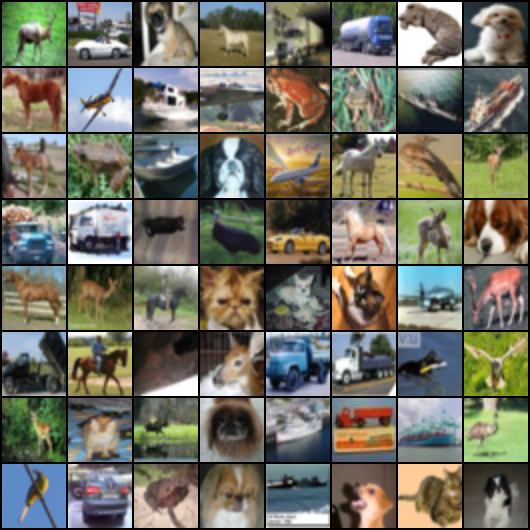

In [24]:
Image.open('output/real_samples.png')

In [25]:
Image.open('output/fake_samples_epoch_024.png')

FileNotFoundError: [Errno 2] No such file or directory: 'output/fake_samples_epoch_024.png'